## Step Comparison

In [ ]:
import copy
import sys
import json
import os
import numpy as np
from roosts.tracking.tracker import Tracker
from roosts.utils.postprocess import Postprocess
from pycocotools.coco import COCO
from roosts.evaluation.roosteval import COCOeval
import matplotlib.pyplot as plt

exp = "3.2eval_resnet101-FPN_detptr_anc10_regsl1_imsz1200_lr0.001_it150k_ckpt39999_strt1"
dataset_name = "roosts_v0.1.0_test"
task = "bbox"
coco_evals = []

def evaluate(predictions):
    coco_gt = COCO(os.path.join(exp, f"{dataset_name}_coco_format.json"))
    coco_dt = coco_gt.loadRes(predictions)

    coco_eval = COCOeval(coco_gt, coco_dt, task)
    coco_eval.evaluate()
    coco_eval.accumulate()
    return coco_eval

In [ ]:
with open(os.path.join(exp, f"{dataset_name}_coco_format.json"), "r") as f:
    gt = json.load(f)
id2scanname = {}
scanname2id = {}
scannames_by_day = {}
for image in gt["images"]:
    scanname = image["file_name"].split("/")[-1].split(".")[0]
    id2scanname[image["id"]] = scanname
    scanname2id[scanname] = image["id"]
    
    day = scanname[4:12]
    if day in scannames_by_day:
        scannames_by_day[day].append(scanname)
    else:
        scannames_by_day[day] = [scanname]
print(len(scannames_by_day))

### Detection with confidence score 0.005

In [ ]:
with open(os.path.join(exp, "coco_instances_results.json"), "r") as f:
    predictions_ = json.load(f)
    # {"image_id": x, "category_id": 0, "bbox": [x, y, w, h], "score": x}

coco_evals.append(("detection", evaluate(predictions_)))

### Detection with confidence score 0.1

In [ ]:
predictions = []
for prediction in predictions_:
    if prediction["score"] >= 0.1:
        predictions.append(prediction)

coco_evals.append(("detection 0.1", evaluate(predictions)))

### Tracking eliminates false positive and improves recall

In [ ]:
detections = {}
for i, prediction in enumerate(predictions):
    scanname = id2scanname[prediction["image_id"]]
    detection = {
        'scanname': scanname,
        'det_ID': i,
        'det_score': prediction["score"],
        'im_bbox': np.array([
            prediction["bbox"][0]+prediction["bbox"][2]/2.,
            prediction["bbox"][1]+prediction["bbox"][3]/2.,
            (prediction["bbox"][2]+prediction["bbox"][3])/4.
        ])
    }
    day = scanname[4:12]
    if day in detections:
        detections[day].append(detection)
    else:
        detections[day] = [detection]

tracker = Tracker()
tracked_detections = {}
tracks = {}
print(len(detections), "days in total.")
for i, day in enumerate(detections):
    print("Day", i+1)
    tracked_detections[day], tracks[day] = tracker.tracking(scannames_by_day[day], copy.deepcopy(detections[day]))

predictions = []
for day in tracked_detections:
    for tracked_detection in tracked_detections[day]:
        predictions.append({
            "image_id": scanname2id[tracked_detection["scanname"]],
            "category_id": 0,
            "bbox": [
                tracked_detection["im_bbox"][0]-tracked_detection["im_bbox"][2],
                tracked_detection["im_bbox"][1]-tracked_detection["im_bbox"][2],
                tracked_detection["im_bbox"][2]*2,
                tracked_detection["im_bbox"][2]*2,
            ],
            "score": tracked_detection["det_score"] # if tracked_detection["det_score"] != -1 else 1 # consider box added by tracker
        })
coco_evals.append(("tracking", evaluate(predictions)))

In [ ]:
recall = np.linspace(.0, 1.00, int(np.round((1.00 - .0) / .01)) + 1, endpoint=True)
for model, coco_eval in coco_evals:
    plt.plot(recall, coco_eval.eval['precision'][0, :, 0, 0, -1], label=model)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title(f'IoU threshold = 0.5')
plt.legend()
plt.show()

### Postprocessing eliminates false positive

In [ ]:
coco_evals.append(("postprocessing", evaluate(predictions)))

### Filtering eliminates false positive: at least 2 detections, at least 1 detection with score 0.5, average score 0.15

In [ ]:
coco_evals.append(("filtering", evaluate(predictions)))

## Model Comparison

In [ ]:
EXPs = [
    ("resnet50-c4", "2.1infer_entire_lr_0.00100_anchor_5_size_1200_resnet50-c4_ignore_49999"),
    ("resnet101-rpn", "3.2eval_resnet101-FPN_detptr_anc10_regsl1_imsz1200_lr0.001_it150k_ckpt39999_strt1")
]

In [ ]:
import sys
import json
import os
import numpy as np
from pycocotools.coco import COCO
from roosts.evaluation.roosteval import COCOeval
import matplotlib.pyplot as plt

coco_evals = []

for model, exp in EXPs:
    # test dataset
    dataset_name = "roosts_v0.1.0_test"
    task = "bbox"
    coco_gt = COCO(os.path.join(exp, f"{dataset_name}_coco_format.json"))

    # predictions
    with open(os.path.join(exp, "coco_instances_results.json"), "r") as f:
        prediction_json = json.load(f)
    coco_dt = coco_gt.loadRes(prediction_json)

    # evaluate
    coco_eval = COCOeval(coco_gt, coco_dt, task)
    coco_eval.evaluate()
    coco_eval.accumulate()
        # coco_eval.eval['precision'].shape = (10, 101, 1, 4, 3)
        # IoU thres 0.50:0.05:0.95
        # recall thres 0:0.01:1
        # 1 class
        # gt filter [[0 ** 2, 1e5 ** 2], [0 ** 2, 32 ** 2], [32 ** 2, 96 ** 2], [96 ** 2, 1e5 ** 2]]
        # dt filter top-scoring [1, 10, 100]
    
    coco_evals.append((model, coco_eval))

In [ ]:
ious = np.linspace(.5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)
recall = np.linspace(.0, 1.00, int(np.round((1.00 - .0) / .01)) + 1, endpoint=True)
for i, iou in enumerate(ious):
    for model, coco_eval in coco_evals:
        plt.plot(recall, coco_eval.eval['precision'][i, :, 0, 0, -1], label=model)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title(f'IoU threshold = {iou}')
    plt.legend()
    plt.show()

In [2]:
with open(os.path.join(exp, f"{dataset_name}_coco_format.json"), "r") as f:
    gt = json.load(f)
id2scanname = {}
scanname2id = {}
scannames_by_day = {}
for image in gt["images"]:
    scanname = image["file_name"].split("/")[-1].split(".")[0]
    id2scanname[image["id"]] = scanname
    scanname2id[scanname] = image["id"]
    
    day = scanname[4:12]
    if day in scannames_by_day:
        scannames_by_day[day].append(scanname)
    else:
        scannames_by_day[day] = [scanname]
print(len(scannames_by_day))

1279


### Detection with confidence score 0.005

In [3]:
with open(os.path.join(exp, "coco_instances_results.json"), "r") as f:
    predictions_ = json.load(f)
    # {"image_id": x, "category_id": 0, "bbox": [x, y, w, h], "score": x}

coco_evals.append(("detection", evaluate(predictions_)))

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.26s).
Accumulating evaluation results...
DONE (t=4.20s).


### Detection with confidence score 0.1

In [4]:
predictions = []
for prediction in predictions_:
    if prediction["score"] >= 0.1:
        predictions.append(prediction)

coco_evals.append(("detection 0.1", evaluate(predictions)))

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.97s).
Accumulating evaluation results...
DONE (t=1.28s).


### Tracking eliminates false positive and improves recall

In [5]:
detections = {}
for i, prediction in enumerate(predictions):
    scanname = id2scanname[prediction["image_id"]]
    detection = {
        'scanname': scanname,
        'det_ID': i,
        'det_score': prediction["score"],
        'im_bbox': np.array([
            prediction["bbox"][0]+prediction["bbox"][2]/2.,
            prediction["bbox"][1]+prediction["bbox"][3]/2.,
            (prediction["bbox"][2]+prediction["bbox"][3])/4.
        ])
    }
    day = scanname[4:12]
    if day in detections:
        detections[day].append(detection)
    else:
        detections[day] = [detection]

tracker = Tracker()
tracked_detections = {}
tracks = {}
print(len(detections), "days in total.")
for i, day in enumerate(detections):
    print("Day", i+1)
    tracked_detections[day], tracks[day] = tracker.tracking(scannames_by_day[day], copy.deepcopy(detections[day]))

predictions = []
for day in tracked_detections:
    for tracked_detection in tracked_detections[day]:
        predictions.append({
            "image_id": scanname2id[tracked_detection["scanname"]],
            "category_id": 0,
            "bbox": [
                tracked_detection["im_bbox"][0]-tracked_detection["im_bbox"][2],
                tracked_detection["im_bbox"][1]-tracked_detection["im_bbox"][2],
                tracked_detection["im_bbox"][2]*2,
                tracked_detection["im_bbox"][2]*2,
            ],
            "score": tracked_detection["det_score"] # if tracked_detection["det_score"] != -1 else 1 # consider box added by tracker
        })
coco_evals.append(("tracking", evaluate(predictions)))

1277 days in total.
Day 1


Tracking: 100%|██████████| 31/31 [00:00<00:00, 549.94it/s]


Day 2


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1601.85it/s]


Day 3


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1550.82it/s]


Day 4


Tracking: 100%|██████████| 34/34 [00:00<00:00, 296.84it/s]


Day 5


Tracking: 100%|██████████| 29/29 [00:00<00:00, 1236.74it/s]


Day 6


Tracking: 100%|██████████| 23/23 [00:00<00:00, 701.74it/s]


Day 7


Tracking: 100%|██████████| 31/31 [00:00<00:00, 794.75it/s]


Day 8


Tracking: 100%|██████████| 33/33 [00:00<00:00, 585.55it/s]


Day 9


Tracking: 100%|██████████| 17/17 [00:00<00:00, 400.39it/s]


Day 10


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3432.84it/s]


Day 11


Tracking: 100%|██████████| 22/22 [00:00<00:00, 2514.43it/s]


Day 12


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1815.34it/s]


Day 13


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2264.74it/s]


Day 14


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1915.13it/s]


Day 15


Tracking: 100%|██████████| 29/29 [00:00<00:00, 334.55it/s]


Day 16


Tracking: 100%|██████████| 13/13 [00:00<00:00, 548.80it/s]


Day 17


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1364.51it/s]


Day 18


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1463.05it/s]


Day 19


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1275.54it/s]


Day 20


Tracking: 100%|██████████| 23/23 [00:00<00:00, 2103.55it/s]


Day 21


Tracking: 100%|██████████| 31/31 [00:00<00:00, 855.55it/s]


Day 22


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2710.70it/s]


Day 23


Tracking: 100%|██████████| 32/32 [00:00<00:00, 811.40it/s]


Day 24


Tracking: 100%|██████████| 19/19 [00:00<00:00, 673.03it/s]


Day 25


Tracking: 100%|██████████| 31/31 [00:00<00:00, 656.06it/s]


Day 26


Tracking: 100%|██████████| 31/31 [00:00<00:00, 1072.45it/s]


Day 27


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2171.27it/s]


Day 28


Tracking: 100%|██████████| 17/17 [00:00<00:00, 2192.73it/s]


Day 29


Tracking: 100%|██████████| 15/15 [00:00<00:00, 710.71it/s]


Day 30


Tracking: 100%|██████████| 41/41 [00:00<00:00, 340.25it/s]


Day 31


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1871.11it/s]


Day 32


Tracking: 100%|██████████| 18/18 [00:00<00:00, 2050.17it/s]


Day 33


Tracking: 100%|██████████| 18/18 [00:00<00:00, 927.20it/s]


Day 34


Tracking: 100%|██████████| 61/61 [00:00<00:00, 727.50it/s]


Day 35


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1586.75it/s]


Day 36


Tracking: 100%|██████████| 24/24 [00:00<00:00, 1001.64it/s]


Day 37


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1515.57it/s]


Day 38


Tracking: 100%|██████████| 12/12 [00:00<00:00, 5014.11it/s]


Day 39


Tracking: 100%|██████████| 29/29 [00:00<00:00, 627.18it/s]


Day 40


Tracking: 100%|██████████| 17/17 [00:00<00:00, 2766.48it/s]


Day 41


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1401.37it/s]


Day 42


Tracking: 100%|██████████| 6/6 [00:00<00:00, 1447.23it/s]


Day 43


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1069.66it/s]


Day 44


Tracking: 100%|██████████| 14/14 [00:00<00:00, 2242.09it/s]


Day 45


Tracking: 100%|██████████| 41/41 [00:00<00:00, 804.21it/s]


Day 46


Tracking: 100%|██████████| 27/27 [00:00<00:00, 3638.78it/s]


Day 47


Tracking: 100%|██████████| 29/29 [00:00<00:00, 1109.24it/s]


Day 48


Tracking: 100%|██████████| 26/26 [00:00<00:00, 2349.19it/s]


Day 49


Tracking: 100%|██████████| 14/14 [00:00<00:00, 1677.58it/s]


Day 50


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2829.64it/s]


Day 51


Tracking: 100%|██████████| 23/23 [00:00<00:00, 2352.21it/s]


Day 52


Tracking: 100%|██████████| 17/17 [00:00<00:00, 675.01it/s]


Day 53


Tracking: 100%|██████████| 20/20 [00:00<00:00, 922.96it/s]


Day 54


Tracking: 100%|██████████| 32/32 [00:00<00:00, 1111.87it/s]


Day 55


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1211.00it/s]


Day 56


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2437.26it/s]


Day 57


Tracking: 100%|██████████| 53/53 [00:00<00:00, 482.53it/s]


Day 58


Tracking: 100%|██████████| 40/40 [00:00<00:00, 610.42it/s]


Day 59


Tracking: 100%|██████████| 33/33 [00:00<00:00, 890.11it/s]


Day 60


Tracking: 100%|██████████| 6/6 [00:00<00:00, 1481.56it/s]


Day 61


Tracking: 100%|██████████| 35/35 [00:00<00:00, 1932.88it/s]


Day 62


Tracking: 100%|██████████| 30/30 [00:00<00:00, 2151.70it/s]


Day 63


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1603.94it/s]


Day 64


Tracking: 100%|██████████| 11/11 [00:00<00:00, 614.78it/s]


Day 65


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1752.25it/s]


Day 66


Tracking: 100%|██████████| 38/38 [00:00<00:00, 239.17it/s]


Day 67


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1173.47it/s]


Day 68


Tracking: 100%|██████████| 11/11 [00:00<00:00, 591.43it/s]


Day 69


Tracking: 100%|██████████| 11/11 [00:00<00:00, 418.70it/s]


Day 70


Tracking: 100%|██████████| 38/38 [00:00<00:00, 594.09it/s]


Day 71


Tracking: 100%|██████████| 48/48 [00:00<00:00, 262.99it/s]


Day 72


Tracking: 100%|██████████| 40/40 [00:00<00:00, 606.86it/s]


Day 73


Tracking: 100%|██████████| 23/23 [00:00<00:00, 811.57it/s]


Day 74


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1286.31it/s]


Day 75


Tracking: 100%|██████████| 36/36 [00:00<00:00, 1308.96it/s]


Day 76


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2906.66it/s]


Day 77


Tracking: 100%|██████████| 48/48 [00:00<00:00, 434.30it/s]


Day 78


Tracking: 100%|██████████| 20/20 [00:00<00:00, 976.51it/s]


Day 79


Tracking: 100%|██████████| 20/20 [00:00<00:00, 752.77it/s]


Day 80


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1018.62it/s]


Day 81


Tracking: 100%|██████████| 15/15 [00:00<00:00, 2171.79it/s]


Day 82


Tracking: 100%|██████████| 14/14 [00:00<00:00, 924.39it/s]


Day 83


Tracking: 100%|██████████| 24/24 [00:00<00:00, 347.27it/s]


Day 84


Tracking: 100%|██████████| 20/20 [00:00<00:00, 480.83it/s]


Day 85


Tracking: 100%|██████████| 62/62 [00:00<00:00, 1225.15it/s]


Day 86


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1111.20it/s]


Day 87


Tracking: 100%|██████████| 25/25 [00:00<00:00, 1418.97it/s]


Day 88


Tracking: 100%|██████████| 63/63 [00:00<00:00, 452.22it/s]


Day 89


Tracking: 100%|██████████| 49/49 [00:00<00:00, 1050.98it/s]


Day 90


Tracking: 100%|██████████| 47/47 [00:00<00:00, 758.51it/s]


Day 91


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2158.67it/s]


Day 92


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2226.60it/s]


Day 93


Tracking: 100%|██████████| 20/20 [00:00<00:00, 3191.65it/s]


Day 94


Tracking: 100%|██████████| 16/16 [00:00<00:00, 1660.33it/s]


Day 95


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1105.41it/s]


Day 96


Tracking: 100%|██████████| 53/53 [00:00<00:00, 375.09it/s]


Day 97


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1900.12it/s]


Day 98


Tracking: 100%|██████████| 52/52 [00:00<00:00, 483.23it/s]


Day 99


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2196.52it/s]


Day 100


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2593.08it/s]


Day 101


Tracking: 100%|██████████| 46/46 [00:00<00:00, 504.98it/s]


Day 102


Tracking: 100%|██████████| 10/10 [00:00<00:00, 2257.19it/s]


Day 103


Tracking: 100%|██████████| 19/19 [00:00<00:00, 802.15it/s]


Day 104


Tracking: 100%|██████████| 20/20 [00:00<00:00, 930.19it/s]


Day 105


Tracking: 100%|██████████| 20/20 [00:00<00:00, 918.63it/s]


Day 106


Tracking: 100%|██████████| 36/36 [00:00<00:00, 1142.83it/s]


Day 107


Tracking: 100%|██████████| 18/18 [00:00<00:00, 333.36it/s]


Day 108


Tracking: 100%|██████████| 18/18 [00:00<00:00, 587.47it/s]


Day 109


Tracking: 100%|██████████| 19/19 [00:00<00:00, 769.29it/s]


Day 110


Tracking: 100%|██████████| 24/24 [00:00<00:00, 627.15it/s]


Day 111


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1483.47it/s]


Day 112


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2400.17it/s]


Day 113


Tracking: 100%|██████████| 21/21 [00:00<00:00, 688.50it/s]


Day 114


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1235.29it/s]


Day 115


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2356.14it/s]


Day 116


Tracking: 100%|██████████| 18/18 [00:00<00:00, 928.98it/s]


Day 117


Tracking: 100%|██████████| 53/53 [00:00<00:00, 298.74it/s]


Day 118


Tracking: 100%|██████████| 24/24 [00:00<00:00, 1352.75it/s]


Day 119


Tracking: 100%|██████████| 18/18 [00:00<00:00, 5984.26it/s]


Day 120


Tracking: 100%|██████████| 14/14 [00:00<00:00, 646.55it/s]


Day 121


Tracking: 100%|██████████| 16/16 [00:00<00:00, 2877.86it/s]


Day 122


Tracking: 100%|██████████| 11/11 [00:00<00:00, 566.83it/s]


Day 123


Tracking: 100%|██████████| 30/30 [00:00<00:00, 504.76it/s]


Day 124


Tracking: 100%|██████████| 19/19 [00:00<00:00, 562.25it/s]


Day 125


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1079.24it/s]


Day 126


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1688.16it/s]


Day 127


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2455.55it/s]


Day 128


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1138.52it/s]


Day 129


Tracking: 100%|██████████| 7/7 [00:00<00:00, 1108.31it/s]


Day 130


Tracking: 100%|██████████| 11/11 [00:00<00:00, 6484.52it/s]


Day 131


Tracking: 100%|██████████| 20/20 [00:00<00:00, 545.98it/s]


Day 132


Tracking: 100%|██████████| 15/15 [00:00<00:00, 644.95it/s]


Day 133


Tracking: 100%|██████████| 19/19 [00:00<00:00, 451.51it/s]


Day 134


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1960.20it/s]


Day 135


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1443.87it/s]


Day 136


Tracking: 100%|██████████| 11/11 [00:00<00:00, 675.15it/s]


Day 137


Tracking: 100%|██████████| 17/17 [00:00<00:00, 968.99it/s]


Day 138


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2924.15it/s]


Day 139


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1386.28it/s]


Day 140


Tracking: 100%|██████████| 19/19 [00:00<00:00, 782.74it/s]


Day 141


Tracking: 100%|██████████| 20/20 [00:00<00:00, 375.79it/s]


Day 142


Tracking: 100%|██████████| 19/19 [00:00<00:00, 467.27it/s]


Day 143


Tracking: 100%|██████████| 19/19 [00:00<00:00, 506.85it/s]


Day 144


Tracking: 100%|██████████| 31/31 [00:00<00:00, 502.25it/s]


Day 145


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2643.22it/s]


Day 146


Tracking: 100%|██████████| 28/28 [00:00<00:00, 564.48it/s]


Day 147


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1372.24it/s]


Day 148


Tracking: 100%|██████████| 39/39 [00:00<00:00, 1003.70it/s]


Day 149


Tracking: 100%|██████████| 17/17 [00:00<00:00, 836.85it/s]


Day 150


Tracking: 100%|██████████| 18/18 [00:00<00:00, 433.58it/s]


Day 151


Tracking: 100%|██████████| 6/6 [00:00<00:00, 1621.82it/s]


Day 152


Tracking: 100%|██████████| 19/19 [00:00<00:00, 734.29it/s]


Day 153


Tracking: 100%|██████████| 40/40 [00:00<00:00, 1102.54it/s]


Day 154


Tracking: 100%|██████████| 19/19 [00:00<00:00, 442.97it/s]


Day 155


Tracking: 100%|██████████| 19/19 [00:00<00:00, 930.63it/s]


Day 156


Tracking: 100%|██████████| 11/11 [00:00<00:00, 811.51it/s]


Day 157


Tracking: 100%|██████████| 11/11 [00:00<00:00, 584.48it/s]


Day 158


Tracking: 100%|██████████| 20/20 [00:00<00:00, 631.75it/s]


Day 159


Tracking: 100%|██████████| 11/11 [00:00<00:00, 764.39it/s]


Day 160


Tracking: 100%|██████████| 19/19 [00:00<00:00, 664.91it/s]


Day 161


Tracking: 100%|██████████| 17/17 [00:00<00:00, 925.97it/s]


Day 162


Tracking: 100%|██████████| 19/19 [00:00<00:00, 440.20it/s]


Day 163


Tracking: 100%|██████████| 10/10 [00:00<00:00, 475.30it/s]


Day 164


Tracking: 100%|██████████| 39/39 [00:00<00:00, 295.52it/s]


Day 165


Tracking: 100%|██████████| 18/18 [00:00<00:00, 572.54it/s]


Day 166


Tracking: 100%|██████████| 19/19 [00:00<00:00, 396.82it/s]


Day 167


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1108.52it/s]


Day 168


Tracking: 100%|██████████| 18/18 [00:00<00:00, 832.01it/s]


Day 169


Tracking: 100%|██████████| 12/12 [00:00<00:00, 3862.45it/s]


Day 170


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1857.79it/s]


Day 171


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1871.75it/s]


Day 172


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1155.51it/s]


Day 173


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1121.64it/s]


Day 174


Tracking: 100%|██████████| 20/20 [00:00<00:00, 487.92it/s]


Day 175


Tracking: 100%|██████████| 11/11 [00:00<00:00, 545.08it/s]


Day 176


Tracking: 100%|██████████| 12/12 [00:00<00:00, 533.38it/s]


Day 177


Tracking: 100%|██████████| 19/19 [00:00<00:00, 830.81it/s]


Day 178


Tracking: 100%|██████████| 11/11 [00:00<00:00, 791.36it/s]


Day 179


Tracking: 100%|██████████| 23/23 [00:00<00:00, 247.21it/s]


Day 180


Tracking: 100%|██████████| 24/24 [00:00<00:00, 960.24it/s]


Day 181


Tracking: 100%|██████████| 20/20 [00:00<00:00, 946.62it/s]


Day 182


Tracking: 100%|██████████| 11/11 [00:00<00:00, 800.20it/s]


Day 183


Tracking: 100%|██████████| 12/12 [00:00<00:00, 719.35it/s]


Day 184


Tracking: 100%|██████████| 12/12 [00:00<00:00, 974.00it/s]


Day 185


Tracking: 100%|██████████| 11/11 [00:00<00:00, 680.34it/s]


Day 186


Tracking: 100%|██████████| 44/44 [00:00<00:00, 553.62it/s]


Day 187


Tracking: 100%|██████████| 11/11 [00:00<00:00, 703.52it/s]


Day 188


Tracking: 100%|██████████| 11/11 [00:00<00:00, 735.15it/s]


Day 189


Tracking: 100%|██████████| 40/40 [00:00<00:00, 508.37it/s]


Day 190


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1304.82it/s]


Day 191


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1204.74it/s]


Day 192


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1572.33it/s]


Day 193


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1028.31it/s]


Day 194


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1539.04it/s]


Day 195


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1407.10it/s]


Day 196


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1398.01it/s]


Day 197


Tracking: 100%|██████████| 11/11 [00:00<00:00, 884.64it/s]


Day 198


Tracking: 100%|██████████| 12/12 [00:00<00:00, 3477.14it/s]


Day 199


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1950.54it/s]


Day 200


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1203.86it/s]


Day 201


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1509.59it/s]


Day 202


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1731.48it/s]


Day 203


Tracking: 100%|██████████| 18/18 [00:00<00:00, 706.24it/s]


Day 204


Tracking: 100%|██████████| 11/11 [00:00<00:00, 445.10it/s]


Day 205


Tracking: 100%|██████████| 11/11 [00:00<00:00, 363.97it/s]


Day 206


Tracking: 100%|██████████| 20/20 [00:00<00:00, 809.71it/s]


Day 207


Tracking: 100%|██████████| 19/19 [00:00<00:00, 287.40it/s]


Day 208


Tracking: 100%|██████████| 19/19 [00:00<00:00, 792.24it/s]


Day 209


Tracking: 100%|██████████| 17/17 [00:00<00:00, 581.50it/s]


Day 210


Tracking: 100%|██████████| 18/18 [00:00<00:00, 647.26it/s]


Day 211


Tracking: 100%|██████████| 17/17 [00:00<00:00, 653.78it/s]


Day 212


Tracking: 100%|██████████| 32/32 [00:00<00:00, 379.58it/s]


Day 213


Tracking: 100%|██████████| 39/39 [00:00<00:00, 316.59it/s]


Day 214


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1608.76it/s]


Day 215


Tracking: 100%|██████████| 29/29 [00:00<00:00, 600.16it/s]


Day 216


Tracking: 100%|██████████| 20/20 [00:00<00:00, 781.51it/s]


Day 217


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1635.32it/s]


Day 218


Tracking: 100%|██████████| 11/11 [00:00<00:00, 681.62it/s]


Day 219


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1611.00it/s]


Day 220


Tracking: 100%|██████████| 29/29 [00:00<00:00, 643.64it/s]


Day 221


Tracking: 100%|██████████| 32/32 [00:00<00:00, 656.11it/s]


Day 222


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1045.45it/s]


Day 223


Tracking: 100%|██████████| 11/11 [00:00<00:00, 362.34it/s]


Day 224


Tracking: 100%|██████████| 11/11 [00:00<00:00, 601.91it/s]


Day 225


Tracking: 100%|██████████| 18/18 [00:00<00:00, 474.26it/s]


Day 226


Tracking: 100%|██████████| 44/44 [00:00<00:00, 484.64it/s]


Day 227


Tracking: 100%|██████████| 23/23 [00:00<00:00, 738.55it/s]


Day 228


Tracking: 100%|██████████| 19/19 [00:00<00:00, 566.85it/s]


Day 229


Tracking: 100%|██████████| 11/11 [00:00<00:00, 438.95it/s]


Day 230


Tracking: 100%|██████████| 27/27 [00:00<00:00, 1131.61it/s]


Day 231


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2337.18it/s]


Day 232


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2957.28it/s]


Day 233


Tracking: 100%|██████████| 40/40 [00:00<00:00, 1376.61it/s]


Day 234


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1295.19it/s]


Day 235


Tracking: 100%|██████████| 38/38 [00:00<00:00, 688.32it/s]


Day 236


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1405.53it/s]


Day 237


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1485.14it/s]


Day 238


Tracking: 100%|██████████| 22/22 [00:00<00:00, 4331.53it/s]


Day 239


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2252.48it/s]


Day 240


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1259.86it/s]


Day 241


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1318.17it/s]


Day 242


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1080.92it/s]


Day 243


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1982.11it/s]


Day 244


Tracking: 100%|██████████| 34/34 [00:00<00:00, 1148.39it/s]


Day 245


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1322.40it/s]


Day 246


Tracking: 100%|██████████| 41/41 [00:00<00:00, 889.99it/s]


Day 247


Tracking: 100%|██████████| 15/15 [00:00<00:00, 962.03it/s]


Day 248


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1170.67it/s]


Day 249


Tracking: 100%|██████████| 51/51 [00:00<00:00, 261.64it/s]


Day 250


Tracking: 100%|██████████| 16/16 [00:00<00:00, 838.38it/s]


Day 251


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2578.95it/s]


Day 252


Tracking: 100%|██████████| 17/17 [00:00<00:00, 2095.92it/s]


Day 253


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1272.13it/s]


Day 254


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1135.13it/s]


Day 255


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1157.42it/s]


Day 256


Tracking: 100%|██████████| 24/24 [00:00<00:00, 332.46it/s]


Day 257


Tracking: 100%|██████████| 28/28 [00:00<00:00, 852.06it/s]


Day 258


Tracking: 100%|██████████| 19/19 [00:00<00:00, 669.94it/s]


Day 259


Tracking: 100%|██████████| 40/40 [00:00<00:00, 936.35it/s]


Day 260


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2393.60it/s]


Day 261


Tracking: 100%|██████████| 25/25 [00:00<00:00, 436.90it/s]


Day 262


Tracking: 100%|██████████| 14/14 [00:00<00:00, 391.57it/s]


Day 263


Tracking: 100%|██████████| 51/51 [00:00<00:00, 348.79it/s]


Day 264


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1216.62it/s]


Day 265


Tracking: 100%|██████████| 43/43 [00:00<00:00, 592.21it/s]


Day 266


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1242.93it/s]


Day 267


Tracking: 100%|██████████| 32/32 [00:00<00:00, 984.17it/s]


Day 268


Tracking: 100%|██████████| 14/14 [00:00<00:00, 624.88it/s]


Day 269


Tracking: 100%|██████████| 33/33 [00:00<00:00, 456.13it/s]


Day 270


Tracking: 100%|██████████| 20/20 [00:00<00:00, 695.82it/s]


Day 271


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1448.40it/s]


Day 272


Tracking: 100%|██████████| 23/23 [00:00<00:00, 4258.93it/s]


Day 273


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1621.59it/s]


Day 274


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2379.81it/s]


Day 275


Tracking: 100%|██████████| 41/41 [00:00<00:00, 536.37it/s]


Day 276


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1277.64it/s]


Day 277


Tracking: 100%|██████████| 24/24 [00:00<00:00, 1529.12it/s]


Day 278


Tracking: 100%|██████████| 40/40 [00:00<00:00, 1335.65it/s]


Day 279


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1270.02it/s]


Day 280


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1319.49it/s]


Day 281


Tracking: 100%|██████████| 20/20 [00:00<00:00, 3217.11it/s]


Day 282


Tracking: 100%|██████████| 10/10 [00:00<00:00, 2035.08it/s]


Day 283


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1521.70it/s]


Day 284


Tracking: 100%|██████████| 14/14 [00:00<00:00, 450.57it/s]


Day 285


Tracking: 100%|██████████| 11/11 [00:00<00:00, 697.83it/s]


Day 286


Tracking: 100%|██████████| 27/27 [00:00<00:00, 679.43it/s]


Day 287


Tracking: 100%|██████████| 14/14 [00:00<00:00, 1356.00it/s]


Day 288


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1341.96it/s]


Day 289


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1400.83it/s]


Day 290


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1599.55it/s]


Day 291


Tracking: 100%|██████████| 19/19 [00:00<00:00, 733.58it/s]


Day 292


Tracking: 100%|██████████| 11/11 [00:00<00:00, 710.70it/s]


Day 293


Tracking: 100%|██████████| 12/12 [00:00<00:00, 456.98it/s]


Day 294


Tracking: 100%|██████████| 18/18 [00:00<00:00, 666.70it/s]


Day 295


Tracking: 100%|██████████| 32/32 [00:00<00:00, 738.38it/s]


Day 296


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1498.77it/s]


Day 297


Tracking: 100%|██████████| 5/5 [00:00<00:00, 1240.84it/s]


Day 298


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2223.48it/s]


Day 299


Tracking: 100%|██████████| 25/25 [00:00<00:00, 5178.41it/s]


Day 300


Tracking: 100%|██████████| 36/36 [00:00<00:00, 2495.66it/s]


Day 301


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2394.46it/s]


Day 302


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1491.09it/s]


Day 303


Tracking: 100%|██████████| 19/19 [00:00<00:00, 724.34it/s]


Day 304


Tracking: 100%|██████████| 12/12 [00:00<00:00, 963.06it/s]


Day 305


Tracking: 100%|██████████| 28/28 [00:00<00:00, 615.91it/s]


Day 306


Tracking: 100%|██████████| 23/23 [00:00<00:00, 843.60it/s]


Day 307


Tracking: 100%|██████████| 11/11 [00:00<00:00, 621.79it/s]


Day 308


Tracking: 100%|██████████| 24/24 [00:00<00:00, 937.96it/s]


Day 309


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1249.05it/s]


Day 310


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1093.20it/s]


Day 311


Tracking: 100%|██████████| 31/31 [00:00<00:00, 801.98it/s]


Day 312


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3680.39it/s]


Day 313


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1010.78it/s]


Day 314


Tracking: 100%|██████████| 23/23 [00:00<00:00, 487.54it/s]


Day 315


Tracking: 100%|██████████| 20/20 [00:00<00:00, 10650.85it/s]


Day 316


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1717.76it/s]


Day 317


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3002.76it/s]


Day 318


Tracking: 100%|██████████| 24/24 [00:00<00:00, 993.68it/s]


Day 319


Tracking: 100%|██████████| 6/6 [00:00<00:00, 2312.82it/s]


Day 320


Tracking: 100%|██████████| 23/23 [00:00<00:00, 2534.72it/s]


Day 321


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1065.48it/s]


Day 322


Tracking: 100%|██████████| 13/13 [00:00<00:00, 844.84it/s]


Day 323


Tracking: 100%|██████████| 12/12 [00:00<00:00, 7500.99it/s]


Day 324


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1175.96it/s]


Day 325


Tracking: 100%|██████████| 23/23 [00:00<00:00, 520.71it/s]


Day 326


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2127.22it/s]


Day 327


Tracking: 100%|██████████| 31/31 [00:00<00:00, 347.90it/s]


Day 328


Tracking: 100%|██████████| 40/40 [00:00<00:00, 625.12it/s]


Day 329


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1394.05it/s]


Day 330


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2599.73it/s]


Day 331


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2312.06it/s]


Day 332


Tracking: 100%|██████████| 28/28 [00:00<00:00, 718.85it/s]


Day 333


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1065.11it/s]


Day 334


Tracking: 100%|██████████| 11/11 [00:00<00:00, 673.60it/s]


Day 335


Tracking: 100%|██████████| 27/27 [00:00<00:00, 538.80it/s]


Day 336


Tracking: 100%|██████████| 35/35 [00:00<00:00, 1236.56it/s]


Day 337


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1735.45it/s]


Day 338


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1841.18it/s]


Day 339


Tracking: 100%|██████████| 8/8 [00:00<00:00, 1208.65it/s]


Day 340


Tracking: 100%|██████████| 18/18 [00:00<00:00, 768.95it/s]


Day 341


Tracking: 100%|██████████| 17/17 [00:00<00:00, 453.97it/s]


Day 342


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1023.98it/s]


Day 343


Tracking: 100%|██████████| 22/22 [00:00<00:00, 803.03it/s]


Day 344


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1710.98it/s]


Day 345


Tracking: 100%|██████████| 32/32 [00:00<00:00, 650.59it/s]


Day 346


Tracking: 100%|██████████| 29/29 [00:00<00:00, 733.13it/s]


Day 347


Tracking: 100%|██████████| 42/42 [00:00<00:00, 848.55it/s]


Day 348


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1880.37it/s]


Day 349


Tracking: 100%|██████████| 14/14 [00:00<00:00, 671.88it/s]


Day 350


Tracking: 100%|██████████| 17/17 [00:00<00:00, 999.89it/s]


Day 351


Tracking: 100%|██████████| 17/17 [00:00<00:00, 789.05it/s]


Day 352


Tracking: 100%|██████████| 7/7 [00:00<00:00, 1598.00it/s]


Day 353


Tracking: 100%|██████████| 9/9 [00:00<00:00, 917.19it/s]


Day 354


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3704.03it/s]


Day 355


Tracking: 100%|██████████| 22/22 [00:00<00:00, 2683.18it/s]


Day 356


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1659.72it/s]


Day 357


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1524.65it/s]


Day 358


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1279.55it/s]


Day 359


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1380.94it/s]


Day 360


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1325.99it/s]


Day 361


Tracking: 100%|██████████| 5/5 [00:00<00:00, 648.55it/s]


Day 362


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2653.39it/s]


Day 363


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1511.25it/s]


Day 364


Tracking: 100%|██████████| 13/13 [00:00<00:00, 2105.90it/s]


Day 365


Tracking: 100%|██████████| 15/15 [00:00<00:00, 751.39it/s]


Day 366


Tracking: 100%|██████████| 19/19 [00:00<00:00, 680.09it/s]


Day 367


Tracking: 100%|██████████| 18/18 [00:00<00:00, 961.03it/s]


Day 368


Tracking: 100%|██████████| 18/18 [00:00<00:00, 491.90it/s]


Day 369


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1384.14it/s]


Day 370


Tracking: 100%|██████████| 20/20 [00:00<00:00, 958.31it/s]


Day 371


Tracking: 100%|██████████| 16/16 [00:00<00:00, 831.25it/s]


Day 372


Tracking: 100%|██████████| 16/16 [00:00<00:00, 1578.96it/s]


Day 373


Tracking: 100%|██████████| 19/19 [00:00<00:00, 563.61it/s]


Day 374


Tracking: 100%|██████████| 17/17 [00:00<00:00, 947.25it/s]


Day 375


Tracking: 100%|██████████| 14/14 [00:00<00:00, 768.38it/s]


Day 376


Tracking: 100%|██████████| 17/17 [00:00<00:00, 896.73it/s]


Day 377


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1141.88it/s]


Day 378


Tracking: 100%|██████████| 15/15 [00:00<00:00, 998.07it/s]


Day 379


Tracking: 100%|██████████| 18/18 [00:00<00:00, 765.24it/s]


Day 380


Tracking: 100%|██████████| 10/10 [00:00<00:00, 894.84it/s]


Day 381


Tracking: 100%|██████████| 13/13 [00:00<00:00, 848.56it/s]


Day 382


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1963.22it/s]


Day 383


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1253.47it/s]


Day 384


Tracking: 100%|██████████| 18/18 [00:00<00:00, 733.43it/s]


Day 385


Tracking: 100%|██████████| 18/18 [00:00<00:00, 761.94it/s]


Day 386


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1109.57it/s]


Day 387


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1042.35it/s]


Day 388


Tracking: 100%|██████████| 18/18 [00:00<00:00, 3840.35it/s]


Day 389


Tracking: 100%|██████████| 14/14 [00:00<00:00, 2195.15it/s]


Day 390


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1405.65it/s]


Day 391


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1856.66it/s]


Day 392


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1408.04it/s]


Day 393


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1199.47it/s]


Day 394


Tracking: 100%|██████████| 16/16 [00:00<00:00, 1373.94it/s]


Day 395


Tracking: 100%|██████████| 19/19 [00:00<00:00, 743.34it/s]


Day 396


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1098.92it/s]


Day 397


Tracking: 100%|██████████| 16/16 [00:00<00:00, 660.74it/s]


Day 398


Tracking: 100%|██████████| 17/17 [00:00<00:00, 2082.21it/s]


Day 399


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1213.24it/s]


Day 400


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1524.68it/s]


Day 401


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1466.60it/s]


Day 402


Tracking: 100%|██████████| 16/16 [00:00<00:00, 877.01it/s]


Day 403


Tracking: 100%|██████████| 15/15 [00:00<00:00, 4011.90it/s]


Day 404


Tracking: 100%|██████████| 21/21 [00:00<00:00, 822.02it/s]


Day 405


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1801.77it/s]


Day 406


Tracking: 100%|██████████| 7/7 [00:00<00:00, 662.32it/s]


Day 407


Tracking: 100%|██████████| 18/18 [00:00<00:00, 575.26it/s]


Day 408


Tracking: 100%|██████████| 18/18 [00:00<00:00, 541.30it/s]


Day 409


Tracking: 100%|██████████| 17/17 [00:00<00:00, 412.73it/s]


Day 410


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1634.74it/s]


Day 411


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1669.92it/s]


Day 412


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1205.97it/s]


Day 413


Tracking: 100%|██████████| 17/17 [00:00<00:00, 447.30it/s]


Day 414


Tracking: 100%|██████████| 12/12 [00:00<00:00, 638.91it/s]


Day 415


Tracking: 100%|██████████| 19/19 [00:00<00:00, 506.84it/s]


Day 416


Tracking: 100%|██████████| 21/21 [00:00<00:00, 1434.37it/s]


Day 417


Tracking: 100%|██████████| 19/19 [00:00<00:00, 949.01it/s]


Day 418


Tracking: 100%|██████████| 17/17 [00:00<00:00, 685.94it/s]


Day 419


Tracking: 100%|██████████| 19/19 [00:00<00:00, 5612.89it/s]


Day 420


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1231.28it/s]


Day 421


Tracking: 100%|██████████| 14/14 [00:00<00:00, 3383.09it/s]


Day 422


Tracking: 100%|██████████| 16/16 [00:00<00:00, 2366.40it/s]


Day 423


Tracking: 100%|██████████| 14/14 [00:00<00:00, 1649.17it/s]


Day 424


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1571.25it/s]


Day 425


Tracking: 100%|██████████| 19/19 [00:00<00:00, 750.15it/s]


Day 426


Tracking: 100%|██████████| 17/17 [00:00<00:00, 614.71it/s]


Day 427


Tracking: 100%|██████████| 21/21 [00:00<00:00, 965.77it/s]


Day 428


Tracking: 100%|██████████| 18/18 [00:00<00:00, 4123.97it/s]


Day 429


Tracking: 100%|██████████| 9/9 [00:00<00:00, 698.07it/s]


Day 430


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1613.19it/s]


Day 431


Tracking: 100%|██████████| 16/16 [00:00<00:00, 1285.17it/s]


Day 432


Tracking: 100%|██████████| 10/10 [00:00<00:00, 721.40it/s]


Day 433


Tracking: 100%|██████████| 17/17 [00:00<00:00, 619.82it/s]


Day 434


Tracking: 100%|██████████| 17/17 [00:00<00:00, 533.88it/s]


Day 435


Tracking: 100%|██████████| 16/16 [00:00<00:00, 783.84it/s]


Day 436


Tracking: 100%|██████████| 29/29 [00:00<00:00, 399.45it/s]


Day 437


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1148.51it/s]


Day 438


Tracking: 100%|██████████| 9/9 [00:00<00:00, 902.07it/s]


Day 439


Tracking: 100%|██████████| 15/15 [00:00<00:00, 927.86it/s]


Day 440


Tracking: 100%|██████████| 17/17 [00:00<00:00, 541.16it/s]


Day 441


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1171.41it/s]


Day 442


Tracking: 100%|██████████| 8/8 [00:00<00:00, 785.16it/s]


Day 443


Tracking: 100%|██████████| 14/14 [00:00<00:00, 1072.40it/s]


Day 444


Tracking: 100%|██████████| 16/16 [00:00<00:00, 739.13it/s]


Day 445


Tracking: 100%|██████████| 9/9 [00:00<00:00, 707.55it/s]


Day 446


Tracking: 100%|██████████| 8/8 [00:00<00:00, 971.80it/s]


Day 447


Tracking: 100%|██████████| 10/10 [00:00<00:00, 912.40it/s]


Day 448


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1164.48it/s]


Day 449


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1484.66it/s]


Day 450


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1672.37it/s]


Day 451


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1562.82it/s]


Day 452


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1465.69it/s]


Day 453


Tracking: 100%|██████████| 10/10 [00:00<00:00, 834.01it/s]


Day 454


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1679.74it/s]


Day 455


Tracking: 100%|██████████| 7/7 [00:00<00:00, 1315.83it/s]


Day 456


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1544.06it/s]


Day 457


Tracking: 100%|██████████| 8/8 [00:00<00:00, 1369.57it/s]


Day 458


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2510.29it/s]


Day 459


Tracking: 100%|██████████| 17/17 [00:00<00:00, 615.72it/s]


Day 460


Tracking: 100%|██████████| 19/19 [00:00<00:00, 674.55it/s]


Day 461


Tracking: 100%|██████████| 14/14 [00:00<00:00, 701.98it/s]


Day 462


Tracking: 100%|██████████| 18/18 [00:00<00:00, 561.01it/s]


Day 463


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1470.77it/s]


Day 464


Tracking: 100%|██████████| 18/18 [00:00<00:00, 620.42it/s]


Day 465


Tracking: 100%|██████████| 17/17 [00:00<00:00, 2396.02it/s]


Day 466


Tracking: 100%|██████████| 17/17 [00:00<00:00, 660.55it/s]


Day 467


Tracking: 100%|██████████| 22/22 [00:00<00:00, 1041.09it/s]


Day 468


Tracking: 100%|██████████| 9/9 [00:00<00:00, 588.09it/s]


Day 469


Tracking: 100%|██████████| 23/23 [00:00<00:00, 2485.67it/s]


Day 470


Tracking: 100%|██████████| 23/23 [00:00<00:00, 5416.87it/s]


Day 471


Tracking: 100%|██████████| 23/23 [00:00<00:00, 3791.87it/s]


Day 472


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2453.19it/s]


Day 473


Tracking: 100%|██████████| 20/20 [00:00<00:00, 8082.29it/s]


Day 474


Tracking: 100%|██████████| 22/22 [00:00<00:00, 1051.17it/s]


Day 475


Tracking: 100%|██████████| 9/9 [00:00<00:00, 2287.25it/s]


Day 476


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1480.57it/s]


Day 477


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2158.56it/s]


Day 478


Tracking: 100%|██████████| 9/9 [00:00<00:00, 2142.14it/s]


Day 479


Tracking: 100%|██████████| 9/9 [00:00<00:00, 2335.36it/s]


Day 480


Tracking: 100%|██████████| 21/21 [00:00<00:00, 1510.61it/s]


Day 481


Tracking: 100%|██████████| 21/21 [00:00<00:00, 1576.13it/s]


Day 482


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1067.37it/s]


Day 483


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2367.34it/s]


Day 484


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1515.77it/s]


Day 485


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1265.46it/s]


Day 486


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1970.60it/s]


Day 487


Tracking: 100%|██████████| 10/10 [00:00<00:00, 2404.85it/s]


Day 488


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1317.68it/s]


Day 489


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1686.42it/s]


Day 490


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1277.29it/s]


Day 491


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1734.62it/s]


Day 492


Tracking: 100%|██████████| 43/43 [00:00<00:00, 2073.43it/s]


Day 493


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1529.23it/s]


Day 494


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1566.79it/s]


Day 495


Tracking: 100%|██████████| 20/20 [00:00<00:00, 902.23it/s]


Day 496


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1429.31it/s]


Day 497


Tracking: 100%|██████████| 9/9 [00:00<00:00, 759.78it/s]


Day 498


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2021.74it/s]


Day 499


Tracking: 100%|██████████| 8/8 [00:00<00:00, 1734.80it/s]


Day 500


Tracking: 100%|██████████| 8/8 [00:00<00:00, 2561.21it/s]


Day 501


Tracking: 100%|██████████| 22/22 [00:00<00:00, 1366.10it/s]


Day 502


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1602.05it/s]


Day 503


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1493.74it/s]


Day 504


Tracking: 100%|██████████| 9/9 [00:00<00:00, 2224.70it/s]


Day 505


Tracking: 100%|██████████| 9/9 [00:00<00:00, 6441.76it/s]


Day 506


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1847.15it/s]


Day 507


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1723.02it/s]


Day 508


Tracking: 100%|██████████| 20/20 [00:00<00:00, 627.23it/s]


Day 509


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1128.82it/s]


Day 510


Tracking: 100%|██████████| 20/20 [00:00<00:00, 631.57it/s]


Day 511


Tracking: 100%|██████████| 18/18 [00:00<00:00, 2722.69it/s]


Day 512


Tracking: 100%|██████████| 3/3 [00:00<00:00, 1060.42it/s]


Day 513


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1613.19it/s]


Day 514


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1287.58it/s]


Day 515


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1027.92it/s]


Day 516


Tracking: 100%|██████████| 8/8 [00:00<00:00, 2830.40it/s]


Day 517


Tracking: 100%|██████████| 20/20 [00:00<00:00, 772.88it/s]


Day 518


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1477.33it/s]


Day 519


Tracking: 100%|██████████| 9/9 [00:00<00:00, 623.72it/s]


Day 520


Tracking: 100%|██████████| 6/6 [00:00<00:00, 560.94it/s]


Day 521


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1128.50it/s]


Day 522


Tracking: 100%|██████████| 11/11 [00:00<00:00, 954.02it/s]


Day 523


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1229.39it/s]


Day 524


Tracking: 100%|██████████| 10/10 [00:00<00:00, 2507.51it/s]


Day 525


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2761.77it/s]


Day 526


Tracking: 100%|██████████| 9/9 [00:00<00:00, 2108.99it/s]


Day 527


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2491.22it/s]


Day 528


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1044.67it/s]


Day 529


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1730.74it/s]


Day 530


Tracking: 100%|██████████| 21/21 [00:00<00:00, 2367.62it/s]


Day 531


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2344.57it/s]


Day 532


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2074.03it/s]


Day 533


Tracking: 100%|██████████| 10/10 [00:00<00:00, 3846.22it/s]


Day 534


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1657.97it/s]


Day 535


Tracking: 100%|██████████| 10/10 [00:00<00:00, 2352.12it/s]


Day 536


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1362.06it/s]


Day 537


Tracking: 100%|██████████| 22/22 [00:00<00:00, 1653.25it/s]


Day 538


Tracking: 100%|██████████| 10/10 [00:00<00:00, 815.27it/s]


Day 539


Tracking: 100%|██████████| 5/5 [00:00<00:00, 1024.95it/s]


Day 540


Tracking: 100%|██████████| 9/9 [00:00<00:00, 985.76it/s]


Day 541


Tracking: 100%|██████████| 9/9 [00:00<00:00, 676.13it/s]


Day 542


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1643.79it/s]


Day 543


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1384.66it/s]


Day 544


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1315.65it/s]


Day 545


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1072.32it/s]


Day 546


Tracking: 100%|██████████| 3/3 [00:00<00:00, 1355.92it/s]


Day 547


Tracking: 100%|██████████| 2/2 [00:00<00:00, 897.37it/s]


Day 548


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1574.64it/s]


Day 549


Tracking: 100%|██████████| 9/9 [00:00<00:00, 2306.53it/s]


Day 550


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1290.82it/s]


Day 551


Tracking: 100%|██████████| 2/2 [00:00<00:00, 1874.97it/s]


Day 552


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2164.04it/s]


Day 553


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1711.57it/s]


Day 554


Tracking: 100%|██████████| 9/9 [00:00<00:00, 3091.37it/s]


Day 555


Tracking: 100%|██████████| 7/7 [00:00<00:00, 3356.59it/s]


Day 556


Tracking: 100%|██████████| 5/5 [00:00<00:00, 1974.53it/s]


Day 557


Tracking: 100%|██████████| 9/9 [00:00<00:00, 2369.51it/s]


Day 558


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1536.60it/s]


Day 559


Tracking: 100%|██████████| 8/8 [00:00<00:00, 991.33it/s]


Day 560


Tracking: 100%|██████████| 21/21 [00:00<00:00, 881.14it/s]


Day 561


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1080.47it/s]


Day 562


Tracking: 100%|██████████| 30/30 [00:00<00:00, 1352.65it/s]


Day 563


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1272.67it/s]


Day 564


Tracking: 100%|██████████| 21/21 [00:00<00:00, 1161.15it/s]


Day 565


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1648.42it/s]


Day 566


Tracking: 100%|██████████| 9/9 [00:00<00:00, 776.82it/s]


Day 567


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1563.09it/s]


Day 568


Tracking: 100%|██████████| 8/8 [00:00<00:00, 1237.39it/s]


Day 569


Tracking: 100%|██████████| 30/30 [00:00<00:00, 359.09it/s]


Day 570


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2487.13it/s]


Day 571


Tracking: 100%|██████████| 30/30 [00:00<00:00, 1184.41it/s]


Day 572


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1583.69it/s]


Day 573


Tracking: 100%|██████████| 8/8 [00:00<00:00, 1303.95it/s]


Day 574


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1316.57it/s]


Day 575


Tracking: 100%|██████████| 2/2 [00:00<00:00, 19972.88it/s]


Day 576


Tracking: 100%|██████████| 22/22 [00:00<00:00, 749.57it/s]


Day 577


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1616.65it/s]


Day 578


Tracking: 100%|██████████| 7/7 [00:00<00:00, 1015.99it/s]


Day 579


Tracking: 100%|██████████| 7/7 [00:00<00:00, 915.53it/s]


Day 580


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1204.26it/s]


Day 581


Tracking: 100%|██████████| 9/9 [00:00<00:00, 983.60it/s]


Day 582


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1200.59it/s]


Day 583


Tracking: 100%|██████████| 21/21 [00:00<00:00, 1142.39it/s]


Day 584


Tracking: 100%|██████████| 8/8 [00:00<00:00, 2344.01it/s]


Day 585


Tracking: 100%|██████████| 27/27 [00:00<00:00, 1414.71it/s]


Day 586


Tracking: 100%|██████████| 9/9 [00:00<00:00, 793.77it/s]


Day 587


Tracking: 100%|██████████| 13/13 [00:00<00:00, 2030.31it/s]


Day 588


Tracking: 100%|██████████| 9/9 [00:00<00:00, 2156.95it/s]


Day 589


Tracking: 100%|██████████| 16/16 [00:00<00:00, 1239.45it/s]


Day 590


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1448.25it/s]


Day 591


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2096.77it/s]


Day 592


Tracking: 100%|██████████| 29/29 [00:00<00:00, 1170.71it/s]


Day 593


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2482.24it/s]


Day 594


Tracking: 100%|██████████| 23/23 [00:00<00:00, 2007.93it/s]


Day 595


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1820.91it/s]


Day 596


Tracking: 100%|██████████| 31/31 [00:00<00:00, 882.26it/s]


Day 597


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1357.10it/s]


Day 598


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2223.06it/s]


Day 599


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3247.97it/s]


Day 600


Tracking: 100%|██████████| 20/20 [00:00<00:00, 5670.28it/s]


Day 601


Tracking: 100%|██████████| 9/9 [00:00<00:00, 3398.95it/s]


Day 602


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1420.18it/s]


Day 603


Tracking: 100%|██████████| 44/44 [00:00<00:00, 1055.62it/s]


Day 604


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2267.70it/s]


Day 605


Tracking: 100%|██████████| 23/23 [00:00<00:00, 3171.97it/s]


Day 606


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1266.17it/s]


Day 607


Tracking: 100%|██████████| 23/23 [00:00<00:00, 929.37it/s]


Day 608


Tracking: 100%|██████████| 11/11 [00:00<00:00, 940.12it/s]


Day 609


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1766.70it/s]


Day 610


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3145.87it/s]


Day 611


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1936.92it/s]


Day 612


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1837.73it/s]


Day 613


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1978.32it/s]


Day 614


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1312.32it/s]


Day 615


Tracking: 100%|██████████| 23/23 [00:00<00:00, 2107.00it/s]


Day 616


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1263.34it/s]


Day 617


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2282.22it/s]


Day 618


Tracking: 100%|██████████| 11/11 [00:00<00:00, 541.31it/s]


Day 619


Tracking: 100%|██████████| 23/23 [00:00<00:00, 501.79it/s]


Day 620


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3284.73it/s]


Day 621


Tracking: 100%|██████████| 12/12 [00:00<00:00, 4121.49it/s]


Day 622


Tracking: 100%|██████████| 11/11 [00:00<00:00, 892.08it/s]


Day 623


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1534.89it/s]


Day 624


Tracking: 100%|██████████| 23/23 [00:00<00:00, 2000.48it/s]


Day 625


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2030.24it/s]


Day 626


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1115.61it/s]


Day 627


Tracking: 100%|██████████| 11/11 [00:00<00:00, 821.05it/s]


Day 628


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1374.51it/s]


Day 629


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1917.12it/s]


Day 630


Tracking: 100%|██████████| 32/32 [00:00<00:00, 672.77it/s]


Day 631


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1347.98it/s]


Day 632


Tracking: 100%|██████████| 21/21 [00:00<00:00, 910.63it/s]


Day 633


Tracking: 100%|██████████| 32/32 [00:00<00:00, 996.47it/s]


Day 634


Tracking: 100%|██████████| 44/44 [00:00<00:00, 1108.90it/s]


Day 635


Tracking: 100%|██████████| 12/12 [00:00<00:00, 720.27it/s]


Day 636


Tracking: 100%|██████████| 37/37 [00:00<00:00, 556.70it/s]


Day 637


Tracking: 100%|██████████| 40/40 [00:00<00:00, 383.03it/s]


Day 638


Tracking: 100%|██████████| 23/23 [00:00<00:00, 2439.97it/s]


Day 639


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1214.60it/s]


Day 640


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1224.87it/s]


Day 641


Tracking: 100%|██████████| 20/20 [00:00<00:00, 982.53it/s]


Day 642


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2290.95it/s]


Day 643


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2612.46it/s]


Day 644


Tracking: 100%|██████████| 23/23 [00:00<00:00, 4082.65it/s]


Day 645


Tracking: 100%|██████████| 41/41 [00:00<00:00, 1943.67it/s]


Day 646


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1882.16it/s]


Day 647


Tracking: 100%|██████████| 43/43 [00:00<00:00, 422.51it/s]


Day 648


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1762.31it/s]


Day 649


Tracking: 100%|██████████| 23/23 [00:00<00:00, 891.56it/s]


Day 650


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1571.21it/s]


Day 651


Tracking: 100%|██████████| 28/28 [00:00<00:00, 677.88it/s]


Day 652


Tracking: 100%|██████████| 23/23 [00:00<00:00, 5987.40it/s]


Day 653


Tracking: 100%|██████████| 12/12 [00:00<00:00, 7273.36it/s]


Day 654


Tracking: 100%|██████████| 23/23 [00:00<00:00, 3780.73it/s]


Day 655


Tracking: 100%|██████████| 23/23 [00:00<00:00, 891.31it/s]


Day 656


Tracking: 100%|██████████| 12/12 [00:00<00:00, 3157.17it/s]


Day 657


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1630.81it/s]


Day 658


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1975.88it/s]


Day 659


Tracking: 100%|██████████| 43/43 [00:00<00:00, 1266.22it/s]


Day 660


Tracking: 100%|██████████| 23/23 [00:00<00:00, 4982.39it/s]


Day 661


Tracking: 100%|██████████| 23/23 [00:00<00:00, 5363.56it/s]


Day 662


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1470.41it/s]


Day 663


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1003.16it/s]


Day 664


Tracking: 100%|██████████| 19/19 [00:00<00:00, 4575.25it/s]


Day 665


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2332.29it/s]


Day 666


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1888.07it/s]


Day 667


Tracking: 100%|██████████| 43/43 [00:00<00:00, 259.01it/s]


Day 668


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2420.13it/s]


Day 669


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1106.94it/s]


Day 670


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1531.94it/s]


Day 671


Tracking: 100%|██████████| 24/24 [00:00<00:00, 1364.26it/s]


Day 672


Tracking: 100%|██████████| 11/11 [00:00<00:00, 805.10it/s]


Day 673


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1542.64it/s]


Day 674


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1480.28it/s]


Day 675


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1392.81it/s]


Day 676


Tracking: 100%|██████████| 22/22 [00:00<00:00, 813.49it/s]


Day 677


Tracking: 100%|██████████| 12/12 [00:00<00:00, 927.67it/s]


Day 678


Tracking: 100%|██████████| 21/21 [00:00<00:00, 729.79it/s]


Day 679


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1205.92it/s]


Day 680


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1788.96it/s]


Day 681


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1694.17it/s]


Day 682


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1979.72it/s]


Day 683


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1184.38it/s]


Day 684


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1397.93it/s]


Day 685


Tracking: 100%|██████████| 23/23 [00:00<00:00, 517.06it/s]


Day 686


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1401.74it/s]


Day 687


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2507.93it/s]


Day 688


Tracking: 100%|██████████| 40/40 [00:00<00:00, 1061.08it/s]


Day 689


Tracking: 100%|██████████| 11/11 [00:00<00:00, 4568.96it/s]


Day 690


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1354.53it/s]


Day 691


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1333.94it/s]


Day 692


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2514.98it/s]


Day 693


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1231.91it/s]


Day 694


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1954.57it/s]


Day 695


Tracking: 100%|██████████| 29/29 [00:00<00:00, 465.24it/s]


Day 696


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1119.20it/s]


Day 697


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1438.06it/s]


Day 698


Tracking: 100%|██████████| 20/20 [00:00<00:00, 697.41it/s]


Day 699


Tracking: 100%|██████████| 14/14 [00:00<00:00, 576.97it/s]


Day 700


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1113.68it/s]


Day 701


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1576.57it/s]


Day 702


Tracking: 100%|██████████| 41/41 [00:00<00:00, 900.08it/s]


Day 703


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2705.53it/s]


Day 704


Tracking: 100%|██████████| 35/35 [00:00<00:00, 237.53it/s]


Day 705


Tracking: 100%|██████████| 20/20 [00:00<00:00, 782.23it/s]


Day 706


Tracking: 100%|██████████| 24/24 [00:00<00:00, 687.20it/s]


Day 707


Tracking: 100%|██████████| 38/38 [00:00<00:00, 318.17it/s]


Day 708


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1145.45it/s]


Day 709


Tracking: 100%|██████████| 20/20 [00:00<00:00, 483.93it/s]


Day 710


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1104.75it/s]


Day 711


Tracking: 100%|██████████| 8/8 [00:00<00:00, 1152.88it/s]


Day 712


Tracking: 100%|██████████| 41/41 [00:00<00:00, 780.53it/s]


Day 713


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2936.86it/s]


Day 714


Tracking: 100%|██████████| 12/12 [00:00<00:00, 3817.34it/s]


Day 715


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2569.32it/s]


Day 716


Tracking: 100%|██████████| 9/9 [00:00<00:00, 1476.23it/s]


Day 717


Tracking: 100%|██████████| 25/25 [00:00<00:00, 606.80it/s]


Day 718


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2187.55it/s]


Day 719


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2399.49it/s]


Day 720


Tracking: 100%|██████████| 7/7 [00:00<00:00, 1792.66it/s]


Day 721


Tracking: 100%|██████████| 43/43 [00:00<00:00, 2976.60it/s]


Day 722


Tracking: 100%|██████████| 24/24 [00:00<00:00, 1527.05it/s]


Day 723


Tracking: 100%|██████████| 23/23 [00:00<00:00, 952.52it/s]


Day 724


Tracking: 100%|██████████| 23/23 [00:00<00:00, 832.43it/s]


Day 725


Tracking: 100%|██████████| 15/15 [00:00<00:00, 1535.03it/s]


Day 726


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1064.35it/s]


Day 727


Tracking: 100%|██████████| 22/22 [00:00<00:00, 961.21it/s]


Day 728


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1014.13it/s]


Day 729


Tracking: 100%|██████████| 23/23 [00:00<00:00, 3186.53it/s]


Day 730


Tracking: 100%|██████████| 32/32 [00:00<00:00, 382.64it/s]


Day 731


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1466.93it/s]


Day 732


Tracking: 100%|██████████| 20/20 [00:00<00:00, 982.24it/s]


Day 733


Tracking: 100%|██████████| 22/22 [00:00<00:00, 1613.84it/s]


Day 734


Tracking: 100%|██████████| 24/24 [00:00<00:00, 813.89it/s]


Day 735


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1254.50it/s]


Day 736


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1599.23it/s]


Day 737


Tracking: 100%|██████████| 23/23 [00:00<00:00, 2930.05it/s]


Day 738


Tracking: 100%|██████████| 23/23 [00:00<00:00, 4207.48it/s]


Day 739


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1127.24it/s]


Day 740


Tracking: 100%|██████████| 23/23 [00:00<00:00, 7260.95it/s]


Day 741


Tracking: 100%|██████████| 23/23 [00:00<00:00, 2187.51it/s]


Day 742


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1576.02it/s]


Day 743


Tracking: 100%|██████████| 15/15 [00:00<00:00, 2946.82it/s]


Day 744


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1574.28it/s]


Day 745


Tracking: 100%|██████████| 5/5 [00:00<00:00, 2565.64it/s]


Day 746


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1999.62it/s]


Day 747


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1507.82it/s]


Day 748


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1282.50it/s]


Day 749


Tracking: 100%|██████████| 24/24 [00:00<00:00, 1063.30it/s]


Day 750


Tracking: 100%|██████████| 39/39 [00:00<00:00, 707.69it/s]


Day 751


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1150.53it/s]


Day 752


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1069.33it/s]


Day 753


Tracking: 100%|██████████| 11/11 [00:00<00:00, 837.79it/s]


Day 754


Tracking: 100%|██████████| 28/28 [00:00<00:00, 701.79it/s]


Day 755


Tracking: 100%|██████████| 25/25 [00:00<00:00, 696.01it/s]


Day 756


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1188.16it/s]


Day 757


Tracking: 100%|██████████| 20/20 [00:00<00:00, 980.17it/s]


Day 758


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1505.63it/s]


Day 759


Tracking: 100%|██████████| 28/28 [00:00<00:00, 988.25it/s]


Day 760


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1112.36it/s]


Day 761


Tracking: 100%|██████████| 32/32 [00:00<00:00, 1090.47it/s]


Day 762


Tracking: 100%|██████████| 11/11 [00:00<00:00, 840.68it/s]


Day 763


Tracking: 100%|██████████| 26/26 [00:00<00:00, 543.05it/s]


Day 764


Tracking: 100%|██████████| 20/20 [00:00<00:00, 3326.17it/s]


Day 765


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2027.62it/s]


Day 766


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2099.14it/s]


Day 767


Tracking: 100%|██████████| 26/26 [00:00<00:00, 4163.08it/s]


Day 768


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2648.06it/s]


Day 769


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1999.86it/s]


Day 770


Tracking: 100%|██████████| 24/24 [00:00<00:00, 2828.73it/s]


Day 771


Tracking: 100%|██████████| 24/24 [00:00<00:00, 1841.15it/s]


Day 772


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2810.72it/s]


Day 773


Tracking: 100%|██████████| 11/11 [00:00<00:00, 4104.38it/s]


Day 774


Tracking: 100%|██████████| 12/12 [00:00<00:00, 4075.44it/s]


Day 775


Tracking: 100%|██████████| 16/16 [00:00<00:00, 1977.28it/s]


Day 776


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3587.66it/s]


Day 777


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1188.95it/s]


Day 778


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1050.37it/s]


Day 779


Tracking: 100%|██████████| 23/23 [00:00<00:00, 4103.49it/s]


Day 780


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1185.41it/s]


Day 781


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1721.68it/s]


Day 782


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1114.94it/s]


Day 783


Tracking: 100%|██████████| 23/23 [00:00<00:00, 3377.06it/s]


Day 784


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1878.05it/s]


Day 785


Tracking: 100%|██████████| 11/11 [00:00<00:00, 987.61it/s]


Day 786


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2412.03it/s]


Day 787


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2057.68it/s]


Day 788


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1144.36it/s]


Day 789


Tracking: 100%|██████████| 32/32 [00:00<00:00, 686.95it/s]


Day 790


Tracking: 100%|██████████| 18/18 [00:00<00:00, 2530.16it/s]


Day 791


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2448.77it/s]


Day 792


Tracking: 100%|██████████| 11/11 [00:00<00:00, 849.03it/s]


Day 793


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2447.16it/s]


Day 794


Tracking: 100%|██████████| 20/20 [00:00<00:00, 4034.15it/s]


Day 795


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2145.82it/s]


Day 796


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1006.15it/s]


Day 797


Tracking: 100%|██████████| 24/24 [00:00<00:00, 845.70it/s]


Day 798


Tracking: 100%|██████████| 21/21 [00:00<00:00, 954.03it/s]


Day 799


Tracking: 100%|██████████| 61/61 [00:00<00:00, 384.24it/s]


Day 800


Tracking: 100%|██████████| 12/12 [00:00<00:00, 3179.31it/s]


Day 801


Tracking: 100%|██████████| 30/30 [00:00<00:00, 453.05it/s]


Day 802


Tracking: 100%|██████████| 36/36 [00:00<00:00, 567.71it/s]


Day 803


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1000.23it/s]


Day 804


Tracking: 100%|██████████| 29/29 [00:00<00:00, 742.56it/s]


Day 805


Tracking: 100%|██████████| 23/23 [00:00<00:00, 949.50it/s]


Day 806


Tracking: 100%|██████████| 32/32 [00:00<00:00, 620.77it/s]


Day 807


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1590.51it/s]


Day 808


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1035.84it/s]


Day 809


Tracking: 100%|██████████| 33/33 [00:00<00:00, 377.18it/s]


Day 810


Tracking: 100%|██████████| 24/24 [00:00<00:00, 3355.33it/s]


Day 811


Tracking: 100%|██████████| 32/32 [00:00<00:00, 834.86it/s]


Day 812


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1611.33it/s]


Day 813


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1223.57it/s]


Day 814


Tracking: 100%|██████████| 11/11 [00:00<00:00, 962.60it/s]


Day 815


Tracking: 100%|██████████| 11/11 [00:00<00:00, 945.01it/s]


Day 816


Tracking: 100%|██████████| 10/10 [00:00<00:00, 2224.98it/s]


Day 817


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1804.31it/s]


Day 818


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2387.69it/s]


Day 819


Tracking: 100%|██████████| 33/33 [00:00<00:00, 1906.55it/s]


Day 820


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3100.21it/s]


Day 821


Tracking: 100%|██████████| 57/57 [00:00<00:00, 661.86it/s]


Day 822


Tracking: 100%|██████████| 17/17 [00:00<00:00, 2477.09it/s]


Day 823


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2214.31it/s]


Day 824


Tracking: 100%|██████████| 24/24 [00:00<00:00, 750.42it/s]


Day 825


Tracking: 100%|██████████| 36/36 [00:00<00:00, 594.63it/s]


Day 826


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1571.92it/s]


Day 827


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1020.15it/s]


Day 828


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2606.04it/s]


Day 829


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1935.86it/s]


Day 830


Tracking: 100%|██████████| 22/22 [00:00<00:00, 3990.60it/s]


Day 831


Tracking: 100%|██████████| 40/40 [00:00<00:00, 1268.46it/s]


Day 832


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1960.00it/s]


Day 833


Tracking: 100%|██████████| 42/42 [00:00<00:00, 455.22it/s]


Day 834


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1520.52it/s]


Day 835


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2945.66it/s]


Day 836


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1850.82it/s]


Day 837


Tracking: 100%|██████████| 37/37 [00:00<00:00, 437.98it/s]


Day 838


Tracking: 100%|██████████| 19/19 [00:00<00:00, 902.72it/s]


Day 839


Tracking: 100%|██████████| 11/11 [00:00<00:00, 967.14it/s]


Day 840


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1694.87it/s]


Day 841


Tracking: 100%|██████████| 8/8 [00:00<00:00, 1960.76it/s]


Day 842


Tracking: 100%|██████████| 20/20 [00:00<00:00, 3739.41it/s]


Day 843


Tracking: 100%|██████████| 42/42 [00:00<00:00, 1497.74it/s]


Day 844


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1462.17it/s]


Day 845


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2196.70it/s]


Day 846


Tracking: 100%|██████████| 19/19 [00:00<00:00, 938.77it/s]


Day 847


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1256.73it/s]


Day 848


Tracking: 100%|██████████| 35/35 [00:00<00:00, 1564.59it/s]


Day 849


Tracking: 100%|██████████| 27/27 [00:00<00:00, 612.50it/s]


Day 850


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1401.42it/s]


Day 851


Tracking: 100%|██████████| 4/4 [00:00<00:00, 1464.49it/s]


Day 852


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1560.14it/s]


Day 853


Tracking: 100%|██████████| 11/11 [00:00<00:00, 4689.71it/s]


Day 854


Tracking: 100%|██████████| 24/24 [00:00<00:00, 1466.82it/s]


Day 855


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1652.60it/s]


Day 856


Tracking: 100%|██████████| 55/55 [00:00<00:00, 781.78it/s]


Day 857


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1626.74it/s]


Day 858


Tracking: 100%|██████████| 36/36 [00:00<00:00, 1979.48it/s]


Day 859


Tracking: 100%|██████████| 35/35 [00:00<00:00, 2856.15it/s]


Day 860


Tracking: 100%|██████████| 35/35 [00:00<00:00, 4560.87it/s]


Day 861


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2069.40it/s]


Day 862


Tracking: 100%|██████████| 10/10 [00:00<00:00, 829.88it/s]


Day 863


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2009.48it/s]


Day 864


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1336.66it/s]


Day 865


Tracking: 100%|██████████| 20/20 [00:00<00:00, 428.80it/s]


Day 866


Tracking: 100%|██████████| 12/12 [00:00<00:00, 687.88it/s]


Day 867


Tracking: 100%|██████████| 11/11 [00:00<00:00, 382.48it/s]


Day 868


Tracking: 100%|██████████| 12/12 [00:00<00:00, 538.47it/s]


Day 869


Tracking: 100%|██████████| 27/27 [00:00<00:00, 1116.73it/s]


Day 870


Tracking: 100%|██████████| 18/18 [00:00<00:00, 507.13it/s]


Day 871


Tracking: 100%|██████████| 5/5 [00:00<00:00, 1374.10it/s]


Day 872


Tracking: 100%|██████████| 27/27 [00:00<00:00, 1976.44it/s]


Day 873


Tracking: 100%|██████████| 12/12 [00:00<00:00, 689.10it/s]


Day 874


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1549.91it/s]


Day 875


Tracking: 100%|██████████| 12/12 [00:00<00:00, 582.55it/s]


Day 876


Tracking: 100%|██████████| 11/11 [00:00<00:00, 436.04it/s]


Day 877


Tracking: 100%|██████████| 12/12 [00:00<00:00, 425.17it/s]


Day 878


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3543.03it/s]


Day 879


Tracking: 100%|██████████| 12/12 [00:00<00:00, 3107.66it/s]


Day 880


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1075.93it/s]


Day 881


Tracking: 100%|██████████| 11/11 [00:00<00:00, 4223.48it/s]


Day 882


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1345.82it/s]


Day 883


Tracking: 100%|██████████| 12/12 [00:00<00:00, 379.31it/s]


Day 884


Tracking: 100%|██████████| 20/20 [00:00<00:00, 386.27it/s]


Day 885


Tracking: 100%|██████████| 10/10 [00:00<00:00, 413.24it/s]


Day 886


Tracking: 100%|██████████| 11/11 [00:00<00:00, 639.59it/s]


Day 887


Tracking: 100%|██████████| 11/11 [00:00<00:00, 584.15it/s]


Day 888


Tracking: 100%|██████████| 17/17 [00:00<00:00, 936.65it/s]


Day 889


Tracking: 100%|██████████| 4/4 [00:00<00:00, 2285.72it/s]


Day 890


Tracking: 100%|██████████| 13/13 [00:00<00:00, 845.06it/s]


Day 891


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3431.05it/s]


Day 892


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1753.54it/s]


Day 893


Tracking: 100%|██████████| 28/28 [00:00<00:00, 1936.33it/s]


Day 894


Tracking: 100%|██████████| 18/18 [00:00<00:00, 471.52it/s]


Day 895


Tracking: 100%|██████████| 16/16 [00:00<00:00, 1153.63it/s]


Day 896


Tracking: 100%|██████████| 12/12 [00:00<00:00, 740.73it/s]


Day 897


Tracking: 100%|██████████| 20/20 [00:00<00:00, 369.55it/s]


Day 898


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1164.50it/s]


Day 899


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1023.71it/s]


Day 900


Tracking: 100%|██████████| 11/11 [00:00<00:00, 568.94it/s]


Day 901


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1275.51it/s]


Day 902


Tracking: 100%|██████████| 11/11 [00:00<00:00, 353.79it/s]


Day 903


Tracking: 100%|██████████| 11/11 [00:00<00:00, 698.66it/s]


Day 904


Tracking: 100%|██████████| 27/27 [00:00<00:00, 1171.07it/s]


Day 905


Tracking: 100%|██████████| 11/11 [00:00<00:00, 496.20it/s]


Day 906


Tracking: 100%|██████████| 15/15 [00:00<00:00, 1185.66it/s]


Day 907


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1743.33it/s]


Day 908


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2103.11it/s]


Day 909


Tracking: 100%|██████████| 12/12 [00:00<00:00, 733.56it/s]


Day 910


Tracking: 100%|██████████| 13/13 [00:00<00:00, 419.91it/s]


Day 911


Tracking: 100%|██████████| 27/27 [00:00<00:00, 463.21it/s]


Day 912


Tracking: 100%|██████████| 11/11 [00:00<00:00, 851.26it/s]


Day 913


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1487.34it/s]


Day 914


Tracking: 100%|██████████| 11/11 [00:00<00:00, 632.17it/s]


Day 915


Tracking: 100%|██████████| 20/20 [00:00<00:00, 991.36it/s]


Day 916


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1354.11it/s]


Day 917


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1331.06it/s]


Day 918


Tracking: 100%|██████████| 11/11 [00:00<00:00, 725.86it/s]


Day 919


Tracking: 100%|██████████| 12/12 [00:00<00:00, 875.20it/s]


Day 920


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2085.59it/s]


Day 921


Tracking: 100%|██████████| 12/12 [00:00<00:00, 687.34it/s]


Day 922


Tracking: 100%|██████████| 44/44 [00:00<00:00, 526.76it/s]


Day 923


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1858.11it/s]


Day 924


Tracking: 100%|██████████| 26/26 [00:00<00:00, 1198.29it/s]


Day 925


Tracking: 100%|██████████| 26/26 [00:00<00:00, 2584.72it/s]


Day 926


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1004.58it/s]


Day 927


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1438.42it/s]


Day 928


Tracking: 100%|██████████| 19/19 [00:00<00:00, 578.16it/s]


Day 929


Tracking: 100%|██████████| 12/12 [00:00<00:00, 392.18it/s]


Day 930


Tracking: 100%|██████████| 20/20 [00:00<00:00, 671.60it/s]


Day 931


Tracking: 100%|██████████| 15/15 [00:00<00:00, 721.33it/s]


Day 932


Tracking: 100%|██████████| 11/11 [00:00<00:00, 536.76it/s]


Day 933


Tracking: 100%|██████████| 16/16 [00:00<00:00, 617.10it/s]


Day 934


Tracking: 100%|██████████| 26/26 [00:00<00:00, 4331.07it/s]


Day 935


Tracking: 100%|██████████| 11/11 [00:00<00:00, 653.75it/s]


Day 936


Tracking: 100%|██████████| 11/11 [00:00<00:00, 967.00it/s]


Day 937


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1213.50it/s]


Day 938


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1042.84it/s]


Day 939


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1473.14it/s]


Day 940


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1772.54it/s]


Day 941


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1331.77it/s]


Day 942


Tracking: 100%|██████████| 12/12 [00:00<00:00, 3253.92it/s]


Day 943


Tracking: 100%|██████████| 6/6 [00:00<00:00, 1743.63it/s]


Day 944


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1508.46it/s]


Day 945


Tracking: 100%|██████████| 12/12 [00:00<00:00, 3123.28it/s]


Day 946


Tracking: 100%|██████████| 15/15 [00:00<00:00, 7036.64it/s]


Day 947


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1923.33it/s]


Day 948


Tracking: 100%|██████████| 20/20 [00:00<00:00, 7298.25it/s]


Day 949


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1999.09it/s]


Day 950


Tracking: 100%|██████████| 17/17 [00:00<00:00, 2374.48it/s]


Day 951


Tracking: 100%|██████████| 20/20 [00:00<00:00, 4584.94it/s]


Day 952


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2253.13it/s]


Day 953


Tracking: 100%|██████████| 20/20 [00:00<00:00, 838.53it/s]


Day 954


Tracking: 100%|██████████| 16/16 [00:00<00:00, 760.92it/s]


Day 955


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1043.02it/s]


Day 956


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1124.94it/s]


Day 957


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2511.03it/s]


Day 958


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1491.43it/s]


Day 959


Tracking: 100%|██████████| 11/11 [00:00<00:00, 979.92it/s]


Day 960


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1140.26it/s]


Day 961


Tracking: 100%|██████████| 20/20 [00:00<00:00, 484.53it/s]


Day 962


Tracking: 100%|██████████| 20/20 [00:00<00:00, 805.70it/s]


Day 963


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1127.72it/s]


Day 964


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1441.42it/s]


Day 965


Tracking: 100%|██████████| 20/20 [00:00<00:00, 953.40it/s]


Day 966


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1527.07it/s]


Day 967


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1646.47it/s]


Day 968


Tracking: 100%|██████████| 6/6 [00:00<00:00, 3805.51it/s]


Day 969


Tracking: 100%|██████████| 4/4 [00:00<00:00, 2562.58it/s]


Day 970


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1993.06it/s]


Day 971


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1883.46it/s]


Day 972


Tracking: 100%|██████████| 23/23 [00:00<00:00, 7308.26it/s]


Day 973


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1487.57it/s]


Day 974


Tracking: 100%|██████████| 22/22 [00:00<00:00, 1088.81it/s]


Day 975


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2856.47it/s]


Day 976


Tracking: 100%|██████████| 18/18 [00:00<00:00, 3361.27it/s]


Day 977


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2150.52it/s]


Day 978


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2037.78it/s]


Day 979


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3269.14it/s]


Day 980


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2712.84it/s]


Day 981


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2742.70it/s]


Day 982


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1057.55it/s]


Day 983


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1090.89it/s]


Day 984


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1275.64it/s]


Day 985


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1726.76it/s]


Day 986


Tracking: 100%|██████████| 12/12 [00:00<00:00, 989.69it/s]


Day 987


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1300.08it/s]


Day 988


Tracking: 100%|██████████| 20/20 [00:00<00:00, 675.90it/s]


Day 989


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1293.12it/s]


Day 990


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1095.15it/s]


Day 991


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1100.88it/s]


Day 992


Tracking: 100%|██████████| 11/11 [00:00<00:00, 948.37it/s]


Day 993


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1718.27it/s]


Day 994


Tracking: 100%|██████████| 23/23 [00:00<00:00, 3486.28it/s]


Day 995


Tracking: 100%|██████████| 11/11 [00:00<00:00, 596.11it/s]


Day 996


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2738.55it/s]


Day 997


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1804.70it/s]


Day 998


Tracking: 100%|██████████| 19/19 [00:00<00:00, 830.50it/s]


Day 999


Tracking: 100%|██████████| 11/11 [00:00<00:00, 630.84it/s]


Day 1000


Tracking: 100%|██████████| 22/22 [00:00<00:00, 2035.71it/s]


Day 1001


Tracking: 100%|██████████| 16/16 [00:00<00:00, 1642.41it/s]


Day 1002


Tracking: 100%|██████████| 15/15 [00:00<00:00, 851.58it/s]


Day 1003


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2478.54it/s]


Day 1004


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1163.82it/s]


Day 1005


Tracking: 100%|██████████| 14/14 [00:00<00:00, 985.21it/s]


Day 1006


Tracking: 100%|██████████| 10/10 [00:00<00:00, 495.52it/s]


Day 1007


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1230.62it/s]


Day 1008


Tracking: 100%|██████████| 8/8 [00:00<00:00, 3474.98it/s]


Day 1009


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2190.48it/s]


Day 1010


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1006.60it/s]


Day 1011


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1258.86it/s]


Day 1012


Tracking: 100%|██████████| 15/15 [00:00<00:00, 769.24it/s]


Day 1013


Tracking: 100%|██████████| 10/10 [00:00<00:00, 631.52it/s]


Day 1014


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1125.77it/s]


Day 1015


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1330.91it/s]


Day 1016


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1844.57it/s]


Day 1017


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1999.54it/s]


Day 1018


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1705.48it/s]


Day 1019


Tracking: 100%|██████████| 19/19 [00:00<00:00, 936.96it/s]


Day 1020


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1403.13it/s]


Day 1021


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1621.78it/s]


Day 1022


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1864.59it/s]


Day 1023


Tracking: 100%|██████████| 23/23 [00:00<00:00, 2521.08it/s]


Day 1024


Tracking: 100%|██████████| 20/20 [00:00<00:00, 853.45it/s]


Day 1025


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1178.24it/s]


Day 1026


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2018.23it/s]


Day 1027


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1291.62it/s]


Day 1028


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1272.81it/s]


Day 1029


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1287.59it/s]


Day 1030


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3024.41it/s]


Day 1031


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3489.97it/s]


Day 1032


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3027.78it/s]


Day 1033


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2591.99it/s]


Day 1034


Tracking: 100%|██████████| 20/20 [00:00<00:00, 3647.54it/s]


Day 1035


Tracking: 100%|██████████| 20/20 [00:00<00:00, 6312.92it/s]


Day 1036


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2826.54it/s]


Day 1037


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2297.26it/s]


Day 1038


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1409.45it/s]


Day 1039


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2679.29it/s]


Day 1040


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1842.35it/s]


Day 1041


Tracking: 100%|██████████| 23/23 [00:00<00:00, 3637.87it/s]


Day 1042


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1676.66it/s]


Day 1043


Tracking: 100%|██████████| 20/20 [00:00<00:00, 3611.11it/s]


Day 1044


Tracking: 100%|██████████| 18/18 [00:00<00:00, 2704.65it/s]


Day 1045


Tracking: 100%|██████████| 22/22 [00:00<00:00, 2937.09it/s]


Day 1046


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1640.05it/s]


Day 1047


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2407.20it/s]


Day 1048


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1975.06it/s]


Day 1049


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2830.87it/s]


Day 1050


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1690.33it/s]


Day 1051


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1404.02it/s]


Day 1052


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1994.15it/s]


Day 1053


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1365.25it/s]


Day 1054


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2467.24it/s]


Day 1055


Tracking: 100%|██████████| 19/19 [00:00<00:00, 819.87it/s]


Day 1056


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1117.37it/s]


Day 1057


Tracking: 100%|██████████| 19/19 [00:00<00:00, 4609.66it/s]


Day 1058


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1267.67it/s]


Day 1059


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1922.97it/s]


Day 1060


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1770.50it/s]


Day 1061


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2932.15it/s]


Day 1062


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1500.79it/s]


Day 1063


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1707.30it/s]


Day 1064


Tracking: 100%|██████████| 20/20 [00:00<00:00, 668.39it/s]


Day 1065


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1308.71it/s]


Day 1066


Tracking: 100%|██████████| 7/7 [00:00<00:00, 1428.79it/s]


Day 1067


Tracking: 100%|██████████| 19/19 [00:00<00:00, 771.18it/s]


Day 1068


Tracking: 100%|██████████| 11/11 [00:00<00:00, 844.84it/s]


Day 1069


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1977.94it/s]


Day 1070


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2360.57it/s]


Day 1071


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1418.41it/s]


Day 1072


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1431.68it/s]


Day 1073


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1813.00it/s]


Day 1074


Tracking: 100%|██████████| 17/17 [00:00<00:00, 2277.55it/s]


Day 1075


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1038.92it/s]


Day 1076


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1369.79it/s]


Day 1077


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2293.35it/s]


Day 1078


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1037.88it/s]


Day 1079


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2208.30it/s]


Day 1080


Tracking: 100%|██████████| 15/15 [00:00<00:00, 1165.80it/s]


Day 1081


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2414.81it/s]


Day 1082


Tracking: 100%|██████████| 19/19 [00:00<00:00, 3378.20it/s]


Day 1083


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2082.78it/s]


Day 1084


Tracking: 100%|██████████| 12/12 [00:00<00:00, 5779.27it/s]


Day 1085


Tracking: 100%|██████████| 20/20 [00:00<00:00, 3570.23it/s]


Day 1086


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1058.54it/s]


Day 1087


Tracking: 100%|██████████| 12/12 [00:00<00:00, 845.20it/s]


Day 1088


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2867.54it/s]


Day 1089


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3462.72it/s]


Day 1090


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2229.29it/s]


Day 1091


Tracking: 100%|██████████| 22/22 [00:00<00:00, 2195.97it/s]


Day 1092


Tracking: 100%|██████████| 8/8 [00:00<00:00, 1387.46it/s]


Day 1093


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2320.21it/s]


Day 1094


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2218.46it/s]


Day 1095


Tracking: 100%|██████████| 21/21 [00:00<00:00, 2118.13it/s]


Day 1096


Tracking: 100%|██████████| 14/14 [00:00<00:00, 2292.69it/s]


Day 1097


Tracking: 100%|██████████| 19/19 [00:00<00:00, 833.22it/s]


Day 1098


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1644.99it/s]


Day 1099


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1863.94it/s]


Day 1100


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1158.21it/s]


Day 1101


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1305.07it/s]


Day 1102


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1545.60it/s]


Day 1103


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2344.02it/s]


Day 1104


Tracking: 100%|██████████| 20/20 [00:00<00:00, 3012.39it/s]


Day 1105


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1420.62it/s]


Day 1106


Tracking: 100%|██████████| 10/10 [00:00<00:00, 907.25it/s]


Day 1107


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1505.00it/s]


Day 1108


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1324.91it/s]


Day 1109


Tracking: 100%|██████████| 12/12 [00:00<00:00, 946.80it/s]


Day 1110


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1192.81it/s]


Day 1111


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1768.73it/s]


Day 1112


Tracking: 100%|██████████| 14/14 [00:00<00:00, 701.92it/s]


Day 1113


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1548.54it/s]


Day 1114


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2891.35it/s]


Day 1115


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1975.88it/s]


Day 1116


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1248.06it/s]


Day 1117


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1549.01it/s]


Day 1118


Tracking: 100%|██████████| 20/20 [00:00<00:00, 899.35it/s]


Day 1119


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1393.04it/s]


Day 1120


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2242.82it/s]


Day 1121


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2090.25it/s]


Day 1122


Tracking: 100%|██████████| 12/12 [00:00<00:00, 4371.72it/s]


Day 1123


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1326.01it/s]


Day 1124


Tracking: 100%|██████████| 12/12 [00:00<00:00, 4110.38it/s]


Day 1125


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2395.87it/s]


Day 1126


Tracking: 100%|██████████| 14/14 [00:00<00:00, 1194.13it/s]


Day 1127


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1463.39it/s]


Day 1128


Tracking: 100%|██████████| 14/14 [00:00<00:00, 700.70it/s]


Day 1129


Tracking: 100%|██████████| 14/14 [00:00<00:00, 1583.82it/s]


Day 1130


Tracking: 100%|██████████| 20/20 [00:00<00:00, 884.86it/s]


Day 1131


Tracking: 100%|██████████| 15/15 [00:00<00:00, 598.08it/s]


Day 1132


Tracking: 100%|██████████| 15/15 [00:00<00:00, 707.37it/s]


Day 1133


Tracking: 100%|██████████| 16/16 [00:00<00:00, 717.51it/s]


Day 1134


Tracking: 100%|██████████| 16/16 [00:00<00:00, 1684.67it/s]


Day 1135


Tracking: 100%|██████████| 22/22 [00:00<00:00, 1546.39it/s]


Day 1136


Tracking: 100%|██████████| 13/13 [00:00<00:00, 2187.34it/s]


Day 1137


Tracking: 100%|██████████| 18/18 [00:00<00:00, 3023.65it/s]


Day 1138


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2177.07it/s]


Day 1139


Tracking: 100%|██████████| 11/11 [00:00<00:00, 965.36it/s]


Day 1140


Tracking: 100%|██████████| 12/12 [00:00<00:00, 792.75it/s]


Day 1141


Tracking: 100%|██████████| 14/14 [00:00<00:00, 1496.52it/s]


Day 1142


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1904.63it/s]


Day 1143


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2437.13it/s]


Day 1144


Tracking: 100%|██████████| 24/24 [00:00<00:00, 1408.33it/s]


Day 1145


Tracking: 100%|██████████| 22/22 [00:00<00:00, 2572.98it/s]


Day 1146


Tracking: 100%|██████████| 17/17 [00:00<00:00, 3415.39it/s]


Day 1147


Tracking: 100%|██████████| 17/17 [00:00<00:00, 2713.11it/s]


Day 1148


Tracking: 100%|██████████| 14/14 [00:00<00:00, 2682.15it/s]


Day 1149


Tracking: 100%|██████████| 25/25 [00:00<00:00, 1942.10it/s]


Day 1150


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2157.26it/s]


Day 1151


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1755.31it/s]


Day 1152


Tracking: 100%|██████████| 23/23 [00:00<00:00, 2711.78it/s]


Day 1153


Tracking: 100%|██████████| 14/14 [00:00<00:00, 1470.32it/s]


Day 1154


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3860.54it/s]


Day 1155


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1644.62it/s]


Day 1156


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1423.57it/s]


Day 1157


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3590.73it/s]


Day 1158


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1788.74it/s]


Day 1159


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1864.51it/s]


Day 1160


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2209.37it/s]


Day 1161


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2963.60it/s]


Day 1162


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2027.57it/s]


Day 1163


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3022.23it/s]


Day 1164


Tracking: 100%|██████████| 7/7 [00:00<00:00, 2747.79it/s]


Day 1165


Tracking: 100%|██████████| 5/5 [00:00<00:00, 3037.59it/s]


Day 1166


Tracking: 100%|██████████| 5/5 [00:00<00:00, 1297.02it/s]


Day 1167


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1599.71it/s]


Day 1168


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1064.56it/s]


Day 1169


Tracking: 100%|██████████| 11/11 [00:00<00:00, 963.91it/s]


Day 1170


Tracking: 100%|██████████| 19/19 [00:00<00:00, 924.64it/s]


Day 1171


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2871.02it/s]


Day 1172


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1140.38it/s]


Day 1173


Tracking: 100%|██████████| 17/17 [00:00<00:00, 861.84it/s]


Day 1174


Tracking: 100%|██████████| 19/19 [00:00<00:00, 611.71it/s]


Day 1175


Tracking: 100%|██████████| 17/17 [00:00<00:00, 4448.66it/s]


Day 1176


Tracking: 100%|██████████| 11/11 [00:00<00:00, 711.77it/s]


Day 1177


Tracking: 100%|██████████| 15/15 [00:00<00:00, 1256.88it/s]


Day 1178


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2189.30it/s]


Day 1179


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1609.74it/s]


Day 1180


Tracking: 100%|██████████| 19/19 [00:00<00:00, 2294.48it/s]


Day 1181


Tracking: 100%|██████████| 11/11 [00:00<00:00, 5348.02it/s]


Day 1182


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2814.28it/s]


Day 1183


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1763.57it/s]


Day 1184


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1698.85it/s]


Day 1185


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1888.98it/s]


Day 1186


Tracking: 100%|██████████| 17/17 [00:00<00:00, 820.47it/s]


Day 1187


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1386.95it/s]


Day 1188


Tracking: 100%|██████████| 8/8 [00:00<00:00, 1577.25it/s]


Day 1189


Tracking: 100%|██████████| 1/1 [00:00<00:00, 11949.58it/s]


Day 1190


Tracking: 100%|██████████| 10/10 [00:00<00:00, 1039.84it/s]


Day 1191


Tracking: 100%|██████████| 17/17 [00:00<00:00, 2387.36it/s]


Day 1192


Tracking: 100%|██████████| 10/10 [00:00<00:00, 2407.06it/s]


Day 1193


Tracking: 100%|██████████| 16/16 [00:00<00:00, 1129.25it/s]


Day 1194


Tracking: 100%|██████████| 23/23 [00:00<00:00, 998.62it/s]


Day 1195


Tracking: 100%|██████████| 24/24 [00:00<00:00, 1728.93it/s]


Day 1196


Tracking: 100%|██████████| 22/22 [00:00<00:00, 1393.52it/s]


Day 1197


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2807.77it/s]


Day 1198


Tracking: 100%|██████████| 13/13 [00:00<00:00, 2206.99it/s]


Day 1199


Tracking: 100%|██████████| 22/22 [00:00<00:00, 1932.74it/s]


Day 1200


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1274.13it/s]


Day 1201


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3075.00it/s]


Day 1202


Tracking: 100%|██████████| 22/22 [00:00<00:00, 2401.80it/s]


Day 1203


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1854.12it/s]


Day 1204


Tracking: 100%|██████████| 18/18 [00:00<00:00, 4180.37it/s]


Day 1205


Tracking: 100%|██████████| 24/24 [00:00<00:00, 1329.40it/s]


Day 1206


Tracking: 100%|██████████| 13/13 [00:00<00:00, 2293.99it/s]


Day 1207


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2009.82it/s]


Day 1208


Tracking: 100%|██████████| 10/10 [00:00<00:00, 3255.94it/s]


Day 1209


Tracking: 100%|██████████| 11/11 [00:00<00:00, 889.31it/s]


Day 1210


Tracking: 100%|██████████| 11/11 [00:00<00:00, 3091.90it/s]


Day 1211


Tracking: 100%|██████████| 24/24 [00:00<00:00, 909.35it/s]


Day 1212


Tracking: 100%|██████████| 17/17 [00:00<00:00, 3021.96it/s]


Day 1213


Tracking: 100%|██████████| 11/11 [00:00<00:00, 889.33it/s]


Day 1214


Tracking: 100%|██████████| 25/25 [00:00<00:00, 637.46it/s]


Day 1215


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1333.51it/s]


Day 1216


Tracking: 100%|██████████| 11/11 [00:00<00:00, 789.46it/s]


Day 1217


Tracking: 100%|██████████| 24/24 [00:00<00:00, 1002.63it/s]


Day 1218


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2354.19it/s]


Day 1219


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1044.15it/s]


Day 1220


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1306.39it/s]


Day 1221


Tracking: 100%|██████████| 21/21 [00:00<00:00, 691.36it/s]


Day 1222


Tracking: 100%|██████████| 23/23 [00:00<00:00, 1073.15it/s]


Day 1223


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2475.58it/s]


Day 1224


Tracking: 100%|██████████| 17/17 [00:00<00:00, 2319.41it/s]


Day 1225


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1599.15it/s]


Day 1226


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1099.09it/s]


Day 1227


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2221.35it/s]


Day 1228


Tracking: 100%|██████████| 5/5 [00:00<00:00, 3434.58it/s]


Day 1229


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1463.52it/s]


Day 1230


Tracking: 100%|██████████| 25/25 [00:00<00:00, 800.04it/s]


Day 1231


Tracking: 100%|██████████| 21/21 [00:00<00:00, 1015.76it/s]


Day 1232


Tracking: 100%|██████████| 11/11 [00:00<00:00, 798.29it/s]


Day 1233


Tracking: 100%|██████████| 11/11 [00:00<00:00, 4192.78it/s]


Day 1234


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1209.00it/s]


Day 1235


Tracking: 100%|██████████| 18/18 [00:00<00:00, 991.54it/s]


Day 1236


Tracking: 100%|██████████| 22/22 [00:00<00:00, 866.48it/s]


Day 1237


Tracking: 100%|██████████| 5/5 [00:00<00:00, 1235.29it/s]


Day 1238


Tracking: 100%|██████████| 20/20 [00:00<00:00, 1345.71it/s]


Day 1239


Tracking: 100%|██████████| 17/17 [00:00<00:00, 843.94it/s]


Day 1240


Tracking: 100%|██████████| 18/18 [00:00<00:00, 1050.78it/s]


Day 1241


Tracking: 100%|██████████| 15/15 [00:00<00:00, 1139.53it/s]


Day 1242


Tracking: 100%|██████████| 17/17 [00:00<00:00, 1692.74it/s]


Day 1243


Tracking: 100%|██████████| 20/20 [00:00<00:00, 2249.14it/s]


Day 1244


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1253.53it/s]


Day 1245


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1164.38it/s]


Day 1246


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2893.62it/s]


Day 1247


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2936.25it/s]


Day 1248


Tracking: 100%|██████████| 25/25 [00:00<00:00, 2865.67it/s]


Day 1249


Tracking: 100%|██████████| 25/25 [00:00<00:00, 5484.18it/s]


Day 1250


Tracking: 100%|██████████| 24/24 [00:00<00:00, 3290.62it/s]


Day 1251


Tracking: 100%|██████████| 24/24 [00:00<00:00, 2337.20it/s]


Day 1252


Tracking: 100%|██████████| 11/11 [00:00<00:00, 4098.18it/s]


Day 1253


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1899.52it/s]


Day 1254


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1405.13it/s]


Day 1255


Tracking: 100%|██████████| 18/18 [00:00<00:00, 827.74it/s]


Day 1256


Tracking: 100%|██████████| 25/25 [00:00<00:00, 698.81it/s]


Day 1257


Tracking: 100%|██████████| 17/17 [00:00<00:00, 2008.60it/s]


Day 1258


Tracking: 100%|██████████| 12/12 [00:00<00:00, 3580.54it/s]


Day 1259


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1419.79it/s]


Day 1260


Tracking: 100%|██████████| 19/19 [00:00<00:00, 625.84it/s]


Day 1261


Tracking: 100%|██████████| 19/19 [00:00<00:00, 836.62it/s]


Day 1262


Tracking: 100%|██████████| 18/18 [00:00<00:00, 655.49it/s]


Day 1263


Tracking: 100%|██████████| 20/20 [00:00<00:00, 502.87it/s]


Day 1264


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1139.55it/s]


Day 1265


Tracking: 100%|██████████| 13/13 [00:00<00:00, 1373.55it/s]


Day 1266


Tracking: 100%|██████████| 15/15 [00:00<00:00, 2058.59it/s]


Day 1267


Tracking: 100%|██████████| 18/18 [00:00<00:00, 3317.11it/s]


Day 1268


Tracking: 100%|██████████| 19/19 [00:00<00:00, 1328.73it/s]


Day 1269


Tracking: 100%|██████████| 11/11 [00:00<00:00, 891.08it/s]


Day 1270


Tracking: 100%|██████████| 11/11 [00:00<00:00, 1137.59it/s]


Day 1271


Tracking: 100%|██████████| 21/21 [00:00<00:00, 1204.24it/s]


Day 1272


Tracking: 100%|██████████| 12/12 [00:00<00:00, 2499.71it/s]


Day 1273


Tracking: 100%|██████████| 25/25 [00:00<00:00, 1758.77it/s]


Day 1274


Tracking: 100%|██████████| 11/11 [00:00<00:00, 765.24it/s]


Day 1275


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1468.17it/s]


Day 1276


Tracking: 100%|██████████| 12/12 [00:00<00:00, 1194.39it/s]


Day 1277


Tracking: 100%|██████████| 11/11 [00:00<00:00, 2137.57it/s]


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=14.03s).
Accumulating evaluation results...
DONE (t=4.27s).


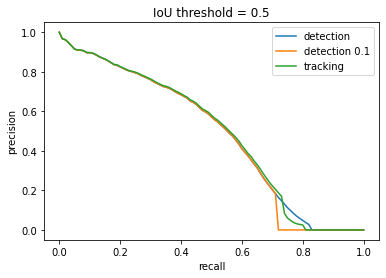

In [6]:
recall = np.linspace(.0, 1.00, int(np.round((1.00 - .0) / .01)) + 1, endpoint=True)
for model, coco_eval in coco_evals:
    plt.plot(recall, coco_eval.eval['precision'][0, :, 0, 0, -1], label=model)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title(f'IoU threshold = 0.5')
plt.legend()
plt.show()

### Postprocessing eliminates false positive

In [ ]:
coco_evals.append(("postprocessing", evaluate(predictions)))

### Filtering eliminates false positive: at least 2 detections, at least 1 detection with score 0.5, average score 0.15

In [ ]:
coco_evals.append(("filtering", evaluate(predictions)))

## Model Comparison

In [1]:
EXPs = [
    ("resnet50-c4", "2.1infer_entire_lr_0.00100_anchor_5_size_1200_resnet50-c4_ignore_49999"),
    ("resnet101-rpn", "3.2eval_resnet101-FPN_detptr_anc10_regsl1_imsz1200_lr0.001_it150k_ckpt39999_strt1")
]

In [3]:
import sys
import json
import os
import numpy as np
from pycocotools.coco import COCO
from roosts.evaluation.roosteval import COCOeval
import matplotlib.pyplot as plt

coco_evals = []

for model, exp in EXPs:
    # test dataset
    dataset_name = "roosts_v0.1.0_test"
    task = "bbox"
    coco_gt = COCO(os.path.join(exp, f"{dataset_name}_coco_format.json"))

    # predictions
    with open(os.path.join(exp, "coco_instances_results.json"), "r") as f:
        prediction_json = json.load(f)
    coco_dt = coco_gt.loadRes(prediction_json)

    # evaluate
    coco_eval = COCOeval(coco_gt, coco_dt, task)
    coco_eval.evaluate()
    coco_eval.accumulate()
        # coco_eval.eval['precision'].shape = (10, 101, 1, 4, 3)
        # IoU thres 0.50:0.05:0.95
        # recall thres 0:0.01:1
        # 1 class
        # gt filter [[0 ** 2, 1e5 ** 2], [0 ** 2, 32 ** 2], [32 ** 2, 96 ** 2], [96 ** 2, 1e5 ** 2]]
        # dt filter top-scoring [1, 10, 100]
    
    coco_evals.append((model, coco_eval))

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.57s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=21.88s).
Accumulating evaluation results...
DONE (t=5.63s).
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=15.23s).
Accumulating evaluation results...
DONE (t=5.12s).


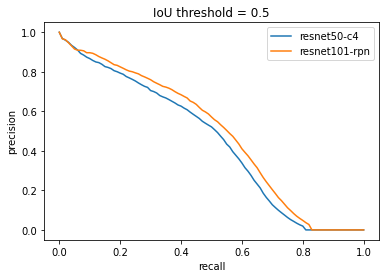

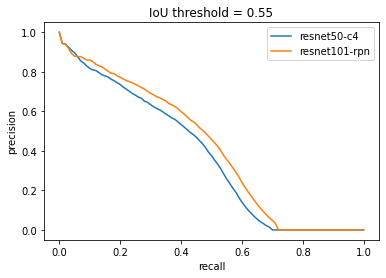

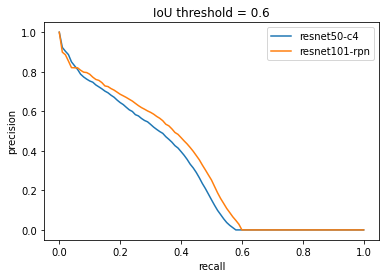

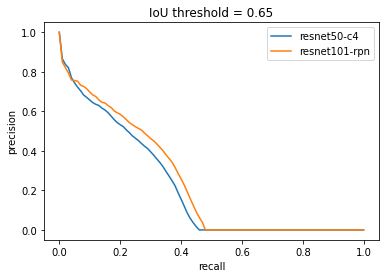

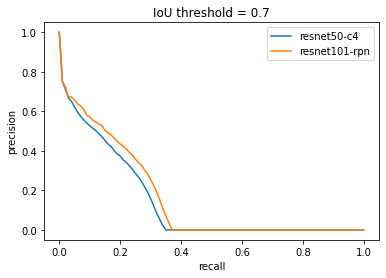

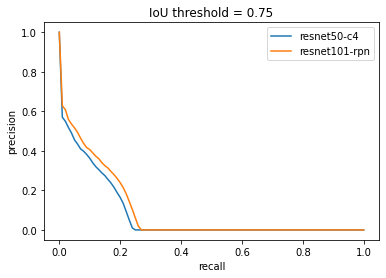

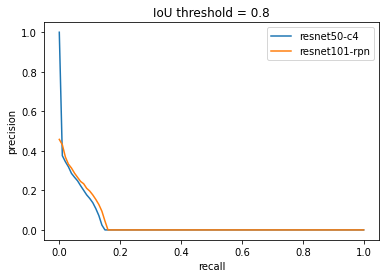

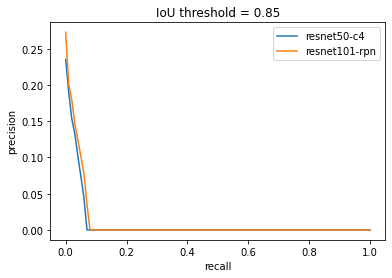

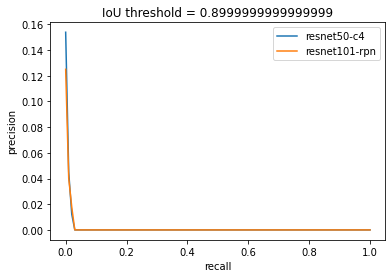

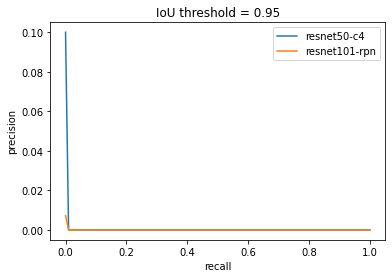

In [10]:
ious = np.linspace(.5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)
recall = np.linspace(.0, 1.00, int(np.round((1.00 - .0) / .01)) + 1, endpoint=True)
for i, iou in enumerate(ious):
    for model, coco_eval in coco_evals:
        plt.plot(recall, coco_eval.eval['precision'][i, :, 0, 0, -1], label=model)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title(f'IoU threshold = {iou}')
    plt.legend()
    plt.show()